In [33]:
import pandas as pd
import numpy as np

In [34]:
### DEFINE BETA VALUES FOR VDF

vot_growth = 0.014

vot_growth_2 = 0.010

vot_growth_3 = 0.010

beta_vals = {} # TBD: compute values based on growth

beta_template_aux = {
    "Period": ["AM", "MD", "PM", "NT"],
    1: [3.13, 3.133, 3.283, 3.286], # [3.820, 3.823, 4.005, 4.009],
    2: [0.715, 0.708, 0.592, 0.708]
}

beta_vals_aux = pd.DataFrame(beta_template_aux)

beta_vals_aux.set_index("Period", inplace=True)

beta_vals[2025] = beta_vals_aux.copy()

beta_vals_aux[1] = beta_vals_aux[1] * (1 + vot_growth) ** (2032-2025)

beta_vals[2032] = beta_vals_aux.copy()

beta_vals_aux[1] = beta_vals_aux[1] * (1 + vot_growth_2) ** (2040-2032)

beta_vals[2040] = beta_vals_aux.copy()

beta_vals_aux[1] = beta_vals_aux[1] * (1 + vot_growth_3) ** (2050-2040)

beta_vals[2050] = beta_vals_aux.copy()

beta_vals_aux[1] = beta_vals_aux[1] * (1 + vot_growth_3) ** (2060-2050)

beta_vals[2060] = beta_vals_aux.copy()


beta_vals

{2025:             1      2
 Period              
 AM      3.130  0.715
 MD      3.133  0.708
 PM      3.283  0.592
 NT      3.286  0.708,
 2032:                1      2
 Period                 
 AM      3.449928  0.715
 MD      3.453235  0.708
 PM      3.618567  0.592
 NT      3.621873  0.708,
 2040:                1      2
 Period                 
 AM      3.735778  0.715
 MD      3.739358  0.708
 PM      3.918389  0.592
 NT      3.921970  0.708,
 2050:                1      2
 Period                 
 AM      4.126623  0.715
 MD      4.130578  0.708
 PM      4.328339  0.592
 NT      4.332295  0.708,
 2060:                1      2
 Period                 
 AM      4.558359  0.715
 MD      4.562728  0.708
 PM      4.781179  0.592
 NT      4.785548  0.708}

In [35]:
### DEFINE LOOKUP TABLE FOR BONUS PER PERIOD

lookup_period_file = r"inputs/LookUp_Period.csv"

lookup_period = pd.read_csv(
    lookup_period_file,
    sep=",",          # `delimiter` y `sep` son equivalentes; elige uno
    encoding="utf-8",
    decimal=".",      # parsea decimales con punto
    thousands=",",    # parsea separador de miles con coma
    quotechar='"',
    index_col=0
)

# Clip y reasignar
lookup_period = lookup_period*0

lookup_period

,Bonus/Mile,4 Periods
Period,,
Night,0.0,
AM-Early,0.0,
AM-Peak,0.0,
AM-Shoulder,0.0,
MD,0.0,
PM-Shoulder,0.0,
PM-Peak,0.0,
PM-Late,0.0,


In [36]:
### DEFINE SEGMENT PARAMETERS
# Default configuration for time periods in traffic data

# TBD: Correctly assess the hard_cap, how does the soft cap work?
# year_soft_cap = [3.6 / 2, 4.2 / 2, 5.15 / 2]

#year_soft_cap = [3.9 / 2, 3.9 / 2, 3.9 / 2]

#TBD: Make this automatically
period_template = [                 # (Period, Hours/Day, Peak/OP, 4Periods tag)
    ("Night",        7, "OP",   "NT"),
    ("AM-Early",     1, "OP",   "AM"),
    ("AM-Peak-1",    1, "Peak", "AM"),
    ("AM-Peak-2",    1, "Peak", "AM"),
    ("AM-Peak-3",    1, "Peak", "AM"),
    ("AM-Shoulder",  1, "OP",   "AM"),
    ("MD",           5, "OP",   "MD"),
    ("PM-Shoulder",  1, "OP",   "PM"),
    ("PM-Peak-1",    1, "Peak", "PM"),
    ("PM-Peak-2",    1, "Peak", "PM"),
    ("PM-Peak-3",    1, "Peak", "PM"),
    ("PM-Late",      3, "OP",   "PM"),
]

rows = []
years = [2025, 2032, 2040, 2050]

# Default time periods list (for reference)
default_time_periods = [
    "Night",
    "AM-Early",
    "AM-Peak-1",
    "AM-Peak-2",
    "AM-Peak-3",
    "AM-Shoulder",
    "MD",
    "PM-Shoulder",
    "PM-Peak-1",
    "PM-Peak-2",
    "PM-Peak-3",
    "PM-Late"
]

# Create the base scenario: hour -> time period mapping
# hour_to_period = {
#     0: "Night",
#     1: "Night",
#     2: "Night",
#     3: "Night",
#     4: "Night",
#     5: "AM-Early",
#     6: "AM-Peak",
#     7: "AM-Shoulder",
#     8: "AM-Shoulder",
#     9: "AM-Shoulder",
#     10: "MD",
#     11: "MD",
#     12: "MD",
#     13: "MD",
#     14: "PM-Shoulder",
#     15: "PM-Shoulder",
#     16: "PM-Peak",
#     17: "PM-Peak",
#     18: "PM-Late",
#     19: "PM-Late",
#     20: "PM-Late",
#     21: "PM-Late",
#     22: "PM-Late",
#     23: "Night"
# }

hour_to_period = {
    0: "Night",
    1: "Night",
    2: "Night",
    3: "Night",
    4: "Night",
    5: "Night",
    6: "AM-Early",
    7: "AM-Peak-1",
    8: "AM-Peak-2",
    9: "AM-Peak-3",
    10: "AM-Shoulder",
    11: "MD",
    12: "MD",
    13: "MD",
    14: "MD",
    15: "MD",
    16: "PM-Shoulder",
    17: "PM-Peak-1",
    18: "PM-Peak-2",
    19: "PM-Peak-3",
    20: "PM-Late",
    21: "PM-Late",
    22: "PM-Late",
    23: "Night"
}

# Define the segments and their parameters

awt_adt = 1.1 # Average weekday traffic (AWT) to average daily traffic (ADT) ratio
peak_factor = 1 # Peak factor for adjustment at peak hour traffic

hov_percentage = pd.DataFrame({
    'Year' : [2025,2032,2040,2050],
    'HOV percentage' : [0,0,0,0]
})

hov_percentage.set_index('Year', inplace=True)

"""
segment_groups = {
    "S1": ["17056956 - I-40 west of Arlington Ave"],
    "S2": ["17056930 - I-40 east of Spence Ln"],
    "S3": ["17056932 - I-24 south of Murfreesboro Pike", "17056947 - I-24 NB Off Ramp to I-40"],
    "S4": ["17056937 - I-24 north of Old Glenrose Ave"],
    "S5": ["17056951 - I-24 south of Briley Pkwy"],
    "S6": ["17056945 - I-24 north Haywood Ln", "17056952 - I-24 south of Haywood Ln"],
    "S7": ["17056946 - I-24 east of Bell Rd", "17056953 - I-24 south of Old Franklin Rd"],
    "S8": ["17056954 - I-24 southeast of Old Hickory Blvd", "17056936 - I-24 northwest of Sam Ridley Pkwy W"],
    "S9": ["17056955 - I-24 northwest of I-840", "17056935 - I-24 northwest of Rocky Fork Rd"],
    "S10": ["17056934 - I-24 east of I-840 WB(5-15)_counts"],
    "S11": ["I-40 Intersection with I 24", "I-40 intersection with 155"],
    "S12": ["I-40 intersection with 155", "I-40 with Old Hickory Blvd"],
    "S13": ["I-40 Intersection with I 24", "I24 Inner Circle"],
    "S14": ["I24 Inner Circle", "I65 Inner Circle"],
    "S15": ["I24 with I65 Inner Circle", "I24 intersection with I65"]
}

"""

# Define segment parameters base
seg_params = pd.DataFrame({
    'SegDir':   ["1NB","1SB","2NB","2SB","3NB","3SB","4NB","4SB","5NB","5SB","6NB","6SB","7NB","7SB","8NB","8SB","9NB","9SB","10NB","10SB"],
    'Length':    [1.3,1.3,1.3,1.3,0.5,0.5,1.6,1.6,2,2,3.6,3.6,2.9,2.9,3.8,3.8,3.4,3.4,4.5,4.5],
    'Inscope':   [0.94,0.94,1,1,1,1,1,1,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94], # [0.82,0.82,0.92,0.92,0.88,0.88,0.88,0.88,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8],  
    'Lanes_GP':  [4]*20, #
    'Lanes_ML':  [2]*20, # Lanes_ML': [2,2,2,2,2,2,2,2,3,3,2,2,2,2], # Do test changing segment 5
    'CapPerLane_GP': [2000]*20,
    'CapPerLane_ML': [1800]*20,
    'Speed_GP':  [55]*6 + [65]*2 + [70]*12,
    'Speed_ML':  [60]*6 + [70]*2 + [70]*12,
    'Alpha_GP':  [1]*20,
    'Beta_GP':   [6]*20,
    'Alpha_ML':  [1.6]*20,
    'Beta_ML':   [6.3]*20,
    'Min_Toll_2016': [None]*20,
    'Max_Toll_2016': [None]*20,
    'LanesGP_AM_Peak': [5]*20,
    'LanesGP_PM_Peak': [5]*20,
})

seg_params.set_index('SegDir', inplace=True)

# Compute capacities as lanes * cap per lane
seg_params['Cap_GP'] = seg_params['Lanes_GP'] * seg_params['CapPerLane_GP']
seg_params['Cap_ML'] = seg_params['Lanes_ML'] * seg_params['CapPerLane_ML']

# Compute peak capacities as Alpha * base capacity
seg_params['CapGP_Peak'] = seg_params['Alpha_GP'] * seg_params['Cap_GP']
seg_params['CapML_Peak'] = seg_params['Alpha_ML'] * seg_params['Cap_ML']

# Optional: if you want integer capacities
seg_params[['Cap_GP','Cap_ML','CapGP_Peak','CapML_Peak']] = seg_params[
    ['Cap_GP','Cap_ML','CapGP_Peak','CapML_Peak']
].astype(int)

# Preview
seg_params

,Length,Inscope,Lanes_GP,Lanes_ML,CapPerLane_GP,CapPerLane_ML,Speed_GP,Speed_ML,Alpha_GP,Beta_GP,Alpha_ML,Beta_ML,Min_Toll_2016,Max_Toll_2016,LanesGP_AM_Peak,LanesGP_PM_Peak,Cap_GP,Cap_ML,CapGP_Peak,CapML_Peak
SegDir,,,,,,,,,,,,,,,,,,,,
1NB,1.3,0.94,4,2,2000,1800,55,60,1,6,1.6,6.3,None,None,5,5,8000,3600,8000,5760
1SB,1.3,0.94,4,2,2000,1800,55,60,1,6,1.6,6.3,None,None,5,5,8000,3600,8000,5760
2NB,1.3,1.00,4,2,2000,1800,55,60,1,6,1.6,6.3,None,None,5,5,8000,3600,8000,5760
2SB,1.3,1.00,4,2,2000,1800,55,60,1,6,1.6,6.3,None,None,5,5,8000,3600,8000,5760
3NB,0.5,1.00,4,2,2000,1800,55,60,1,6,1.6,6.3,None,None,5,5,8000,3600,8000,5760
3SB,0.5,1.00,4,2,2000,1800,55,60,1,6,1.6,6.3,None,None,5,5,8000,3600,8000,5760
4NB,1.6,1.00,4,2,2000,1800,65,70,1,6,1.6,6.3,None,None,5,5,8000,3600,8000,5760
4SB,1.6,1.00,4,2,2000,1800,65,70,1,6,1.6,6.3,None,None,5,5,8000,3600,8000,5760
5NB,2.0,0.94,4,2,2000,1800,70,70,1,6,1.6,6.3,None,None,5,5,8000,3600,8000,5760


In [37]:
# SET CAPACITY FACTORS FOR EACH SEGMENT AND PERIOD

# capacity_factors_data = {
#     "SegDir":       ["1NB","1SB","2NB","2SB","3NB","3SB","4NB","4SB","5NB","5SB","6NB","6SB","7NB","7SB","8NB","8SB","9NB","9SB","10NB","10SB"],
#     "Night":        [1.00, 1.20, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00],
#     "AM-Early":     [0.75, 1.30, 0.80, 1.00, 1.00, 1.10, 1.35, 1.10, 1.05, 1.00, 1.15, 1.00, 1.20, 0.50, 1.10, 0.75, 1.00, 1.00, 1.00, 1.00],
#     "AM-Peak":      [0.70, 1.30, 0.70, 1.00, 0.90, 1.20, 1.10, 1.20, 0.75, 1.00, 1.20, 1.00, 1.00, 0.50, 1.00, 0.75, 1.00, 1.00, 1.00, 1.00],
#     "AM-Shoulder":  [1.00, 1.30, 1.00, 1.00, 1.10, 1.20, 1.20, 1.10, 0.70, 0.90, 1.00, 1.00, 1.40, 0.70, 1.20, 0.85, 1.00, 1.00, 1.00, 1.00],
#     "MD":           [1.00, 1.00, 1.00, 1.00, 1.10, 1.10, 1.10, 1.00, 0.85, 0.80, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00],
#     "PM-Shoulder":  [1.20, 1.00, 1.00, 1.00, 1.15, 1.10, 1.10, 0.80, 0.70, 0.80, 1.00, 0.60, 0.80, 1.00, 0.90, 1.00, 1.00, 1.00, 1.00, 1.00],
#     "PM-Peak":      [1.00, 1.00, 1.00, 1.00, 1.15, 0.90, 1.10, 1.00, 0.60, 0.80, 1.00, 0.50, 0.70, 0.90, 0.85, 0.90, 1.00, 1.00, 1.00, 1.00],
#     "PM-Late":      [1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00]
# }

# capacity_factors_data = {
#     "SegDir": ["10NB","10SB","9NB","9SB","8NB","8SB","7NB","7SB","6NB","6SB","5NB","5SB","4NB","4SB","3NB","3SB","2NB","2SB","1NB","1SB"],
#     "Night":        [1.00, 1.00, 1.00, 1.00, 1.00, 1.20, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00],
#     "AM-Early":     [1.10, 0.75, 1.10, 0.75, 0.75, 1.30, 0.80, 1.00, 1.00, 1.10, 1.35, 1.10, 1.35, 1.10, 1.05, 1.00, 1.05, 1.00, 1.05, 1.00],
#     "AM-Peak":      [1.00, 0.75, 1.00, 0.75, 0.70, 1.30, 0.70, 1.00, 0.90, 1.20, 1.10, 1.20, 1.10, 1.20, 0.75, 1.00, 0.75, 1.00, 0.75, 1.00],
#     "AM-Shoulder":  [1.20, 0.85, 1.20, 0.85, 1.00, 1.30, 1.00, 1.00, 1.10, 1.20, 1.20, 1.10, 1.20, 1.10, 0.70, 0.90, 0.70, 0.90, 0.70, 0.90],
#     "MD":           [1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.10, 1.10, 1.10, 1.00, 1.10, 1.00, 0.85, 0.80, 0.85, 0.80, 0.85, 0.80],
#     "PM-Shoulder":  [0.90, 1.00, 0.90, 1.00, 1.20, 1.00, 1.00, 1.00, 1.15, 1.10, 1.10, 0.80, 1.10, 0.80, 0.70, 0.80, 0.70, 0.80, 0.70, 0.80],
#     "PM-Peak":      [0.85, 0.90, 0.85, 0.90, 1.00, 1.00, 1.00, 1.00, 1.15, 0.90, 1.00, 0.50, 1.00, 0.50, 0.60, 0.80, 0.60, 0.80, 0.60, 0.80],
#     "PM-Late":      [1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00]
# }

capacity_factors_file = 'inputs/capacity_factors_hourly_peaks.csv'

capacity_factors_data = pd.read_csv(capacity_factors_file,
    sep=",",          # `delimiter` y `sep` son equivalentes; elige uno
    encoding="utf-8",
    decimal=".",      # parsea decimales con punto
    thousands=",",    # parsea separador de miles con coma
    quotechar='"',
    index_col=0
)

# Create DF from your original data
df_cf = capacity_factors_data
# Set 'SegDir' as index
# df_cf.set_index('SegDir', inplace=True)

df_cf = df_cf.clip(lower=0.4, upper=1.3)

df_cf.loc['Night', :] = 1

# Transpose matrix to make the calculation

cap_adj = df_cf * seg_params['Cap_GP']

df_cf

,10NB,10SB,11NB,11SB,12NB,12SB,13NB,13SB,14NB,14SB,...,5NB,5SB,6NB,6SB,7NB,7SB,8NB,8SB,9NB,9SB
Period,,,,,,,,,,,,,,,,,,,,,
AM-Early,1.300000,1.300000,0.923403,0.915160,1.206015,0.456605,1.144276,1.3,0.956094,1.300000,...,1.300000,0.999870,1.183511,0.999376,0.999994,0.999986,1.017107,1.125713,1.020730,1.000098
AM-Peak-1,1.000459,1.000061,1.000000,0.634514,1.300000,0.400000,1.000000,1.3,0.840420,1.300000,...,1.000167,1.000496,1.000000,1.000314,0.930507,1.000000,0.884033,1.000000,1.000048,1.000422
AM-Peak-2,1.000862,1.000000,0.917141,0.911143,1.300000,0.492517,1.000000,1.3,1.000000,1.300000,...,1.000000,1.000135,1.000436,1.000000,0.951060,1.000062,0.873506,1.000430,1.000295,1.000000
AM-Peak-3,1.000202,1.000472,1.000000,0.668765,1.300000,0.838525,1.280861,1.3,1.300000,1.300000,...,1.000113,1.000000,1.000000,1.000257,1.000000,1.000421,1.000000,1.000000,1.000056,1.000000
AM-Shoulder,1.000629,1.000000,1.008159,0.728145,1.260144,0.924406,1.300000,1.3,1.300000,1.300000,...,1.000108,1.000000,1.000000,1.000000,1.000163,1.000290,1.000044,1.000764,1.000680,1.000780
MD,1.078460,1.300000,0.691899,0.781150,0.835849,0.787440,1.300000,1.3,1.300000,1.300000,...,1.019958,0.973710,1.037893,1.113525,1.034642,1.132741,1.000167,1.049731,0.980208,1.103445
Night,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
PM-Late,0.591799,0.716519,0.748425,0.903539,0.578312,1.179831,1.208705,1.3,0.976147,1.246399,...,0.669994,0.632106,0.543515,0.652107,0.518949,0.660895,0.525885,0.591934,0.517884,0.590669
PM-Peak-1,1.000000,1.000000,0.891251,0.803322,0.958850,1.053782,1.000000,1.0,1.300000,1.300000,...,1.000000,1.000000,1.000189,1.000000,1.000000,1.000304,1.000028,1.000000,1.000000,1.000000


In [38]:
# SET CAPACITY FACTORS FOR EACH SEGMENT AND PERIOD
pce_factors_file = 'inputs/pce_factors_hourly_peaks.csv'

pce_factors_data = pd.read_csv(pce_factors_file,
    sep=",",          # `delimiter` y `sep` son equivalentes; elige uno
    encoding="utf-8",
    decimal=".",      # parsea decimales con punto
    thousands=",",    # parsea separador de miles con coma
    quotechar='"',
    index_col=0
)

# Create DF from your original data
df_cf = pce_factors_data
# Set 'SegDir' as index
# df_cf.set_index('SegDir', inplace=True)

#Lower upper limit changed to 1.0
# Transpose matrix to make the calculation

pce_adj = df_cf

pce_adj

,10NB,10SB,11NB,11SB,12NB,12SB,13NB,13SB,14NB,14SB,...,5NB,5SB,6NB,6SB,7NB,7SB,8NB,8SB,9NB,9SB
Period,,,,,,,,,,,,,,,,,,,,,
AM-Early,1.000000,1.000000,1.000000,1.00,1.000000,1.00,1.000000,1.000000,1.000000,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
AM-Peak-1,1.000000,1.000000,1.098047,1.15,1.000000,1.15,1.105639,1.000000,1.150000,1.0,...,1.000000,1.000000,1.000266,1.000000,1.150000,1.000002,1.150000,1.000659,1.000000,1.000000
AM-Peak-2,1.000000,1.000153,1.150000,1.15,1.000000,1.15,1.110669,1.000000,1.127861,1.0,...,1.000176,1.000000,1.000000,1.000022,1.150000,1.000000,1.150000,1.000000,1.000000,1.000066
AM-Peak-3,1.000000,1.000000,1.028996,1.15,1.000000,1.15,1.000000,1.000000,1.000000,1.0,...,1.000000,1.000356,1.000098,1.000000,1.000075,1.000000,1.010628,1.000425,1.000000,1.000066
AM-Shoulder,1.000000,1.000267,1.000000,1.15,1.000000,1.15,1.000000,1.000000,1.000000,1.0,...,1.000000,1.000327,1.000140,1.000191,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
MD,1.000000,1.000000,1.000000,1.00,1.000000,1.00,1.000000,1.000000,1.000000,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Night,1.000000,1.000000,1.000000,1.00,1.000000,1.00,1.000000,1.000000,1.000000,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
PM-Late,1.000000,1.000000,1.000000,1.00,1.000000,1.00,1.000000,1.000000,1.000000,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
PM-Peak-1,1.000319,1.000234,1.150000,1.15,1.150000,1.00,1.106226,1.014186,1.000000,1.0,...,1.000272,1.047213,1.000000,1.000320,1.000423,1.000000,1.000000,1.000022,1.000607,1.000156


In [39]:
# SET CAPACITY FACTORS FOR EACH SEGMENT AND PERIOD
suppression_file = 'inputs/suppression_hourly_peaks.csv'

suppression_data = pd.read_csv(suppression_file,
    sep=",",          # `delimiter` y `sep` son equivalentes; elige uno
    encoding="utf-8",
    decimal=".",      # parsea decimales con punto
    thousands=",",    # parsea separador de miles con coma
    quotechar='"',
    index_col=0
)

suppression_data

,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,...,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085
Night,0.90,0.904226,0.908471,0.912737,0.917022,0.921328,0.925654,0.93,0.932477,0.934960,...,1.062509,1.065817,1.069136,1.072465,1.075805,1.079155,1.082515,1.085886,1.089267,1.092659
AM-Early,1.00,1.004232,1.008481,1.012749,1.017034,1.021338,1.025660,1.03,1.033703,1.037419,...,1.172034,1.175309,1.178594,1.181888,1.185191,1.188503,1.191825,1.195156,1.198496,1.201846
AM-Peak-1,1.20,1.209759,1.219597,1.229515,1.239513,1.249593,1.259755,1.27,1.276145,1.282320,...,1.631431,1.641059,1.650743,1.660485,1.670284,1.680141,1.690056,1.700030,1.710063,1.720154
AM-Peak-2,1.20,1.209759,1.219597,1.229515,1.239513,1.249593,1.259755,1.27,1.276145,1.282320,...,1.631431,1.641059,1.650743,1.660485,1.670284,1.680141,1.690056,1.700030,1.710063,1.720154
AM-Peak-3,1.20,1.209759,1.219597,1.229515,1.239513,1.249593,1.259755,1.27,1.276145,1.282320,...,1.631431,1.641059,1.650743,1.660485,1.670284,1.680141,1.690056,1.700030,1.710063,1.720154
AM-Shoulder,1.05,1.058369,1.066804,1.075307,1.083877,1.092516,1.101223,1.11,1.116130,1.122294,...,1.350320,1.356030,1.361765,1.367523,1.373307,1.379114,1.384946,1.390803,1.396685,1.402592
MD,1.02,1.026997,1.034042,1.041136,1.048278,1.055469,1.062710,1.07,1.072480,1.074965,...,1.241005,1.245486,1.249982,1.254495,1.259025,1.263570,1.268133,1.272711,1.277306,1.281918
PM-Shoulder,1.05,1.058369,1.066804,1.075307,1.083877,1.092516,1.101223,1.11,1.116130,1.122294,...,1.350320,1.356030,1.361765,1.367523,1.373307,1.379114,1.384946,1.390803,1.396685,1.402592
PM-Peak-1,1.20,1.209759,1.219597,1.229515,1.239513,1.249593,1.259755,1.27,1.276145,1.282320,...,1.631431,1.641059,1.650743,1.660485,1.670284,1.680141,1.690056,1.700030,1.710063,1.720154
PM-Peak-2,1.20,1.209759,1.219597,1.229515,1.239513,1.249593,1.259755,1.27,1.276145,1.282320,...,1.631431,1.641059,1.650743,1.660485,1.670284,1.680141,1.690056,1.700030,1.710063,1.720154


In [40]:
# SET CAPACITY FACTORS FOR EACH SEGMENT AND PERIOD
suppression_file = 'inputs/suppression_NB_hourly_peaks.csv'

suppression_data_NB = pd.read_csv(suppression_file,
    sep=",",          # `delimiter` y `sep` son equivalentes; elige uno
    encoding="utf-8",
    decimal=".",      # parsea decimales con punto
    thousands=",",    # parsea separador de miles con coma
    quotechar='"',
    index_col=0
)

suppression_data_NB

,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,...,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085
Night,0.90,0.904226,0.908471,0.912737,0.917022,0.921328,0.925654,0.93,0.932477,0.934960,...,1.062509,1.065817,1.069136,1.072465,1.075805,1.079155,1.082515,1.085886,1.089267,1.092659
AM-Early,1.00,1.004232,1.008481,1.012749,1.017034,1.021338,1.025660,1.03,1.033703,1.037419,...,1.172034,1.175309,1.178594,1.181888,1.185191,1.188503,1.191825,1.195156,1.198496,1.201846
AM-Peak-1,1.20,1.209759,1.219597,1.229515,1.239513,1.249593,1.259755,1.27,1.276145,1.282320,...,1.631431,1.641059,1.650743,1.660485,1.670284,1.680141,1.690056,1.700030,1.710063,1.720154
AM-Peak-2,1.20,1.209759,1.219597,1.229515,1.239513,1.249593,1.259755,1.27,1.276145,1.282320,...,1.631431,1.641059,1.650743,1.660485,1.670284,1.680141,1.690056,1.700030,1.710063,1.720154
AM-Peak-3,1.20,1.209759,1.219597,1.229515,1.239513,1.249593,1.259755,1.27,1.276145,1.282320,...,1.631431,1.641059,1.650743,1.660485,1.670284,1.680141,1.690056,1.700030,1.710063,1.720154
AM-Shoulder,1.05,1.058369,1.066804,1.075307,1.083877,1.092516,1.101223,1.11,1.116130,1.122294,...,1.350320,1.356030,1.361765,1.367523,1.373307,1.379114,1.384946,1.390803,1.396685,1.402592
MD,1.02,1.026997,1.034042,1.041136,1.048278,1.055469,1.062710,1.07,1.072480,1.074965,...,1.241005,1.245486,1.249982,1.254495,1.259025,1.263570,1.268133,1.272711,1.277306,1.281918
PM-Shoulder,1.05,1.058369,1.066804,1.075307,1.083877,1.092516,1.101223,1.11,1.116130,1.122294,...,1.350320,1.356030,1.361765,1.367523,1.373307,1.379114,1.384946,1.390803,1.396685,1.402592
PM-Peak-1,1.20,1.209759,1.219597,1.229515,1.239513,1.249593,1.259755,1.11,1.276145,1.282320,...,1.631431,1.641059,1.650743,1.660485,1.670284,1.680141,1.690056,1.700030,1.710063,1.720154
PM-Peak-2,1.20,1.209759,1.219597,1.229515,1.239513,1.249593,1.259755,1.11,1.276145,1.282320,...,1.631431,1.641059,1.650743,1.660485,1.670284,1.680141,1.690056,1.700030,1.710063,1.720154


In [41]:
# SET CAPACITY FACTORS FOR EACH SEGMENT AND PERIOD
suppression_file = 'inputs/suppression_SB_hourly_peaks.csv'

suppression_data_SB = pd.read_csv(suppression_file,
    sep=",",          # `delimiter` y `sep` son equivalentes; elige uno
    encoding="utf-8",
    decimal=".",      # parsea decimales con punto
    thousands=",",    # parsea separador de miles con coma
    quotechar='"',
    index_col=0
)

suppression_data_SB

,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,...,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085
Night,0.90,0.904226,0.908471,0.912737,0.917022,0.921328,0.925654,0.93,0.932477,0.934960,...,1.062509,1.065817,1.069136,1.072465,1.075805,1.079155,1.082515,1.085886,1.089267,1.092659
AM-Early,1.00,1.004232,1.008481,1.012749,1.017034,1.021338,1.025660,1.03,1.033703,1.037419,...,1.172034,1.175309,1.178594,1.181888,1.185191,1.188503,1.191825,1.195156,1.198496,1.201846
AM-Peak-1,1.20,1.209759,1.219597,1.229515,1.239513,1.249593,1.259755,1.11,1.276145,1.282320,...,1.631431,1.641059,1.650743,1.660485,1.670284,1.680141,1.690056,1.700030,1.710063,1.720154
AM-Peak-2,1.20,1.209759,1.219597,1.229515,1.239513,1.249593,1.259755,1.11,1.276145,1.282320,...,1.631431,1.641059,1.650743,1.660485,1.670284,1.680141,1.690056,1.700030,1.710063,1.720154
AM-Peak-3,1.20,1.209759,1.219597,1.229515,1.239513,1.249593,1.259755,1.11,1.276145,1.282320,...,1.631431,1.641059,1.650743,1.660485,1.670284,1.680141,1.690056,1.700030,1.710063,1.720154
AM-Shoulder,1.05,1.058369,1.066804,1.075307,1.083877,1.092516,1.101223,1.11,1.116130,1.122294,...,1.350320,1.356030,1.361765,1.367523,1.373307,1.379114,1.384946,1.390803,1.396685,1.402592
MD,1.02,1.026997,1.034042,1.041136,1.048278,1.055469,1.062710,1.07,1.072480,1.074965,...,1.241005,1.245486,1.249982,1.254495,1.259025,1.263570,1.268133,1.272711,1.277306,1.281918
PM-Shoulder,1.05,1.058369,1.066804,1.075307,1.083877,1.092516,1.101223,1.11,1.116130,1.122294,...,1.350320,1.356030,1.361765,1.367523,1.373307,1.379114,1.384946,1.390803,1.396685,1.402592
PM-Peak-1,1.20,1.209759,1.219597,1.229515,1.239513,1.249593,1.259755,1.27,1.276145,1.282320,...,1.631431,1.641059,1.650743,1.660485,1.670284,1.680141,1.690056,1.700030,1.710063,1.720154
PM-Peak-2,1.20,1.209759,1.219597,1.229515,1.239513,1.249593,1.259755,1.27,1.276145,1.282320,...,1.631431,1.641059,1.650743,1.660485,1.670284,1.680141,1.690056,1.700030,1.710063,1.720154


In [42]:
import numpy as np

def adjusted_cumprod(row, target_year, multiplier):
    years = row.index
    print(row.values)
    factors = 1 + row.values
    
    # Find the index of the target year
    target_idx = list(years).index(target_year)
    
    # Apply multiplier to the target year's factor
    factors[target_idx] *= multiplier
    
    # Calculate cumulative product
    return pd.Series(np.cumprod(factors), index=years)

In [43]:
### IMPORT GROWTHS FOR EACH CLASS
file_path_growths = r"inputs/growths_per_segment.csv"
base_growth_df = pd.read_csv(
    file_path_growths,
    delimiter=',',
    encoding='utf-8',
    decimal='.',        # ← this tells pandas how to parse decimals
    thousands=',',       # ← this tells pandas how to parse thousands
    quotechar='"'
)

base_growth_df = base_growth_df.iloc[:, 1:]
project_years = base_growth_df.columns[1:].tolist()

base_growth_df.iloc[:, 1:] = base_growth_df.iloc[:, 1:]

base_growth_df.iloc[:, 1:] = base_growth_df.iloc[:, 1:]*0.7 # 0.55

base_growth_df.iloc[:, 1:] =  base_growth_df.iloc[:, 1:] + 1

base_growth_df.loc[:, '2032'] *= 1.12

base_growth_df

,SegmentMapped,2026,2027,2028,2029,2030,2031,2032,2033,2034,...,2062,2063,2064,2065,2066,2067,2068,2069,2070,2071
0,S1,1.013249,1.013249,1.013249,1.013249,1.013249,1.016030,1.137953,1.016030,1.016030,...,1.009854,1.009854,1.009854,1.009854,1.005913,1.005913,1.005913,1.005913,1.005913,1.005913
1,S2,1.017908,1.017908,1.017908,1.017908,1.017908,1.022060,1.144707,1.022060,1.022060,...,1.011662,1.011662,1.011662,1.011662,1.006997,1.006997,1.006997,1.006997,1.006997,1.006997
2,S3,1.016118,1.016118,1.016118,1.016118,1.016118,1.020257,1.142688,1.020257,1.020257,...,1.010881,1.010881,1.010881,1.010881,1.006528,1.006528,1.006528,1.006528,1.006528,1.006528
3,S4,1.015505,1.015505,1.015505,1.015505,1.015505,1.019539,1.141884,1.019539,1.019539,...,1.010626,1.010626,1.010626,1.010626,1.006376,1.006376,1.006376,1.006376,1.006376,1.006376
4,S5,1.012654,1.012654,1.012654,1.012654,1.012654,1.016074,1.138003,1.016074,1.016074,...,1.009476,1.009476,1.009476,1.009476,1.005686,1.005686,1.005686,1.005686,1.005686,1.005686
5,S6,1.012820,1.012820,1.012820,1.012820,1.012820,1.016404,1.138373,1.016404,1.016404,...,1.009518,1.009518,1.009518,1.009518,1.005711,1.005711,1.005711,1.005711,1.005711,1.005711
6,S7,1.014032,1.014032,1.014032,1.014032,1.014032,1.017801,1.139937,1.017801,1.017801,...,1.010008,1.010008,1.010008,1.010008,1.006005,1.006005,1.006005,1.006005,1.006005,1.006005
7,S8,1.013676,1.013676,1.013676,1.013676,1.013676,1.017534,1.139638,1.017534,1.017534,...,1.009842,1.009842,1.009842,1.009842,1.005905,1.005905,1.005905,1.005905,1.005905,1.005905
8,S9,1.012547,1.012547,1.012547,1.012547,1.012547,1.016058,1.137985,1.016058,1.016058,...,1.009410,1.009410,1.009410,1.009410,1.005646,1.005646,1.005646,1.005646,1.005646,1.005646
9,S10,1.014240,1.014240,1.014240,1.014240,1.014240,1.017272,1.139345,1.017272,1.017272,...,1.010166,1.010166,1.010166,1.010166,1.006100,1.006100,1.006100,1.006100,1.006100,1.006100


In [44]:
### IMPORT COUNTS AND SEPARATE BY CLASS AND PERIODS

file_path_counts = r"inputs/counts_by_hour_grouped_sorted.csv"
base_counts_df = pd.read_csv(
    file_path_counts,
    delimiter=',',
    encoding='utf-8',
    decimal='.',        # ← this tells pandas how to parse decimals
    thousands=',',       # ← this tells pandas how to parse thousands
    quotechar='"'
)

# --- Ajustar direcciones ---
base_counts_df["Direction"] = base_counts_df["Direction"].replace({"EB": "SB", "WB": "NB"})

# --- Crear columna Seg/Dir ---
base_counts_df["Seg/Dir"] = base_counts_df["Segment"].astype(str) + base_counts_df["Direction"]

# --- Función para procesar cada clase ---
def process_class(df_class):
    # Convertir a formato largo
    df_long = df_class.melt(
        id_vars=["Seg/Dir", "Segment", "Direction", "Class", "AADT"],
        value_vars=[str(h) for h in range(24)],
        var_name="Hour",
        value_name="Volume"
    )
    
    # Mapear hora a periodo
    df_long["Hour"] = df_long["Hour"].astype(int)
    df_long["Period"] = df_long["Hour"].map(hour_to_period)
    
    # Agregar por Segment/Direction/Class/Period
    df_period = df_long.groupby(
        ["Seg/Dir", "Segment", "Direction", "Class", "Period"], as_index=False, sort=False
    ).agg({"Volume": "mean"}).round(0)
    
    # Pivot a formato ancho (periodos como columnas)
    period_order = df_period['Period'].unique()
    df_wide = df_period.pivot(
        index=["Seg/Dir", "Segment", "Direction", "Class"],
        columns="Period",
        values="Volume"
    )[period_order].reset_index()
    
    # Mantener solo Seg/Dir como índice
    df_proc = df_wide.drop(columns=["Class", "Direction", "Segment"]).set_index("Seg/Dir")
    
    return df_proc

# --- Separar por clases y procesar ---
dfs_by_class = {}
for cls in base_counts_df["Class"].unique():
    df_cls = base_counts_df[base_counts_df["Class"] == cls].copy()
    dfs_by_class[cls] = process_class(df_cls)


'''
Vehicle Classifications follow FHWA standards:
Lights: FHWA Classes 1-3 [Light Duty Vehicles]
Medium A: Classes 4-5 [Buses and Single Unit 2 axles trucks] 
Medium B: Class 6-7 [Single Unit 3 or 4 axles Trucks]
Heavy A: Classes 8-10 [Single Trailer 3 or more axles trucks]
Heavy B: Classes 11-13 [Combination Trucks Multitrailer Trucks]
'''

# --- Ejemplo de uso ---
df_lights = dfs_by_class["Lights"]
df_mediumA = dfs_by_class["Medium A"]
df_mediumB = dfs_by_class["Medium B"]
df_heavyA = dfs_by_class["Heavy A"]
df_heavyB = dfs_by_class["Heavy B"]

df_lights

Period,Night,AM-Early,AM-Peak-1,AM-Peak-2,AM-Peak-3,AM-Shoulder,MD,PM-Shoulder,PM-Peak-1,PM-Peak-2,PM-Peak-3,PM-Late
Seg/Dir,,,,,,,,,,,,
S10NB,1123.0,5039.0,3149.0,2830.0,2917.0,2879.0,3352.0,3598.0,3838.0,3901.0,3731.0,1996.0
S10SB,727.0,2850.0,2773.0,2550.0,2427.0,2699.0,3874.0,3700.0,4034.0,4057.0,3441.0,2054.0
S11NB,1397.0,5278.0,6093.0,5120.0,5222.0,5124.0,3734.0,4721.0,5599.0,5926.0,5400.0,2727.0
S11SB,1357.0,3040.0,2284.0,3009.0,2119.0,2477.0,4161.0,4962.0,5086.0,6201.0,6375.0,3560.0
S12NB,1503.0,5991.0,8296.0,7198.0,5999.0,5481.0,4183.0,5348.0,5149.0,5187.0,2104.0,2197.0
S12SB,904.0,2958.0,2346.0,2980.0,4319.0,4605.0,4364.0,7360.0,7016.0,5584.0,5152.0,2688.0
S13NB,1229.0,6795.0,7584.0,7075.0,6964.0,6664.0,4510.0,6304.0,6229.0,5475.0,4728.0,2124.0
S13SB,1025.0,3009.0,5258.0,5281.0,5078.0,5286.0,5340.0,10150.0,8039.0,7178.0,5853.0,2606.0
S14NB,1062.0,6156.0,6246.0,6031.0,5841.0,5296.0,3812.0,5400.0,5712.0,5244.0,3804.0,1699.0


In [45]:
# --- Lista de periodos según tus columnas ---
period_cols = ["Night","AM-Early","AM-Peak-1","AM-Peak-2","AM-Peak-3","AM-Shoulder","MD","PM-Shoulder","PM-Peak-1","PM-Peak-2","PM-Peak-3","PM-Late"]

# Diccionario de dataframes por clase
class_dfs = {
    "Lights": df_lights,
    "Medium A": df_mediumA,
    "Medium B": df_mediumB,
    "Heavy A": df_heavyA,
    "Heavy B": df_heavyB
}

projected_long_by_class = {}

for cls_name, df_class in class_dfs.items():
    df = df_class.copy()
    
    # Resetear índice Seg/Dir y extraer Segment y Direction
    df = df.reset_index()
    df["Segment"] = df["Seg/Dir"].str.extract(r"(\d+)")[0]    # solo los números
    df["Direction"] = df["Seg/Dir"].str.extract(r"([A-Z]+)")[0]  # solo las letras
    df["Class"] = cls_name
    
    # Melt usando las columnas de periodos
    df_long = df.melt(
        id_vars=["Seg/Dir","Segment","Direction","Class"],
        value_vars=period_cols,
        var_name="Period",
        value_name="AADT "+str(df["Class"][0])
    )
    
    # Normalizar SegDir (opcional)
    df_long["SegDir"] = df_long["Seg/Dir"].str.strip().str.upper().str.lstrip("S")
    
    projected_long_by_class[cls_name] = df_long

# Ejemplo: ver Lights
projected_long_lights_df = projected_long_by_class["Lights"]
projected_long_mediumA_df = projected_long_by_class["Medium A"]
projected_long_mediumB_df = projected_long_by_class["Medium B"]
projected_long_heaviesA_df = projected_long_by_class["Heavy A"]
projected_long_heaviesB_df = projected_long_by_class["Heavy B"]
projected_long_mediumA_df


,Seg/Dir,Segment,Direction,Class,Period,AADT Medium A,SegDir
0,S10NB,10,S,Medium A,Night,36.0,10NB
1,S10SB,10,S,Medium A,Night,32.0,10SB
2,S11NB,11,S,Medium A,Night,37.0,11NB
3,S11SB,11,S,Medium A,Night,39.0,11SB
4,S12NB,12,S,Medium A,Night,46.0,12NB
...,...,...,...,...,...,...,...
427,S7SB,7,S,Medium A,PM-Late,34.0,7SB
428,S8NB,8,S,Medium A,PM-Late,24.0,8NB
429,S8SB,8,S,Medium A,PM-Late,28.0,8SB
430,S9NB,9,S,Medium A,PM-Late,34.0,9NB


In [46]:
rows = []

for year in years:
    for seg in seg_params.index:  # e.g., "1NB", "1SB", etc.
        seg_data = seg_params.loc[seg]
        # Extraer parte numérica y dirección
        seg_numeric = ''.join(filter(str.isdigit, seg))  # e.g., "10"
        direction = seg[len(seg_numeric):]       
        for p, hrs, peak, tag in period_template:
            rows.append({
                "Year": year,
                "SegDir": seg,
                "Segment": seg_numeric,        
                "Direction": direction,     
                "Period": p,
                "Hours/Day": hrs,
                "Peak": peak,
                "4Periods": tag,

                # Parámetros técnicos
                "Length": seg_data["Length"],
                "Speed GP": seg_data["Speed_GP"],
                "Capacity GP": seg_data["CapPerLane_GP"] * seg_data["Lanes_GP"],
                "Alpha GP": seg_data["Alpha_GP"],
                "Beta GP": seg_data["Beta_GP"],
                "Speed ML": seg_data["Speed_ML"],
                "Capacity ML": seg_data["CapPerLane_ML"] * seg_data["Lanes_ML"],
                "Alpha ML": seg_data["Alpha_ML"],
                "Beta ML": seg_data["Beta_ML"],
                "MinToll": 0.2,
                "MinCapture": 0.05
            })

# --- plantilla base ---
first_model_df = pd.DataFrame(rows)

# --- merge para todas las clases ---
for cls_name, df_proj in projected_long_by_class.items():
    proj_merge_df = df_proj[["SegDir", "Period", f"AADT {cls_name}"]].copy()
    proj_merge_df.rename(columns={"AADT": f"AADT {cls_name}"}, inplace=True)

    first_model_df = first_model_df.merge(
        proj_merge_df,
        on=["SegDir", "Period"],
        how="left"
    )

# --- 1. Reshape growths a formato largo ---
growths_long = base_growth_df.melt(
    id_vars="SegmentMapped",
    var_name="Year",
    value_name="AnnualGrowth"
).copy()
growths_long["Year"] = growths_long["Year"].astype(int)

# --- 2. Calcular crecimiento acumulado desde 2025 ---
# Ordenamos por año y aplicamos cumprod
growths_long = growths_long.sort_values(["SegmentMapped", "Year"])
growths_long["GrowthFactor"] = (growths_long["AnnualGrowth"]).groupby(growths_long["SegmentMapped"]).cumprod()

# Ahora GrowthFactor(y) = factor acumulado 2025→y

# --- 3. Preparar plantilla ---
fm = first_model_df.copy()
fm["Year"] = fm["Year"].astype(int)
fm["Segment"] = fm["Segment"].astype(str).str.replace(r"^S", "", regex=True)
fm["SegmentMapped"] = "S" + fm["Segment"].astype(str)

# --- 4. Merge GrowthFactor ---
fm = fm.merge(
    growths_long[["SegmentMapped", "Year", "GrowthFactor"]],
    on=["SegmentMapped", "Year"],
    how="left"
)

fm["GrowthFactor"] = fm["GrowthFactor"].fillna(1.0)

# --- 5. Aplicar GrowthFactor a todas las clases ---
for cls_name in projected_long_by_class.keys():
    col = f"AADT {cls_name}"
    if col in fm.columns:
        fm[col] = (fm[col].fillna(0) * fm["GrowthFactor"]).round(1)

# --- 6. Limpieza ---
fm = fm.drop(columns=["SegmentMapped"])   # opcional

first_model_df = fm

first_model_df


,Year,SegDir,Segment,Direction,Period,Hours/Day,Peak,4Periods,Length,Speed GP,...,Alpha ML,Beta ML,MinToll,MinCapture,AADT Lights,AADT Medium A,AADT Medium B,AADT Heavy A,AADT Heavy B,GrowthFactor
0,2025,1NB,1,NB,Night,7,OP,NT,1.3,55,...,1.6,6.3,0.2,0.05,1397.0,37.0,10.0,248.0,30.0,1.000000
1,2025,1NB,1,NB,AM-Early,1,OP,AM,1.3,55,...,1.6,6.3,0.2,0.05,5278.0,151.0,79.0,257.0,12.0,1.000000
2,2025,1NB,1,NB,AM-Peak-1,1,Peak,AM,1.3,55,...,1.6,6.3,0.2,0.05,6093.0,156.0,54.0,266.0,5.0,1.000000
3,2025,1NB,1,NB,AM-Peak-2,1,Peak,AM,1.3,55,...,1.6,6.3,0.2,0.05,5120.0,209.0,48.0,424.0,8.0,1.000000
4,2025,1NB,1,NB,AM-Peak-3,1,Peak,AM,1.3,55,...,1.6,6.3,0.2,0.05,5222.0,277.0,57.0,606.0,15.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,2050,10SB,10,SB,PM-Shoulder,1,OP,PM,4.5,70,...,1.6,6.3,0.2,0.05,6327.7,171.0,42.8,348.9,15.4,1.710196
956,2050,10SB,10,SB,PM-Peak-1,1,Peak,PM,4.5,70,...,1.6,6.3,0.2,0.05,6898.9,150.5,27.4,393.3,1.7,1.710196
957,2050,10SB,10,SB,PM-Peak-2,1,Peak,PM,4.5,70,...,1.6,6.3,0.2,0.05,6938.3,208.6,34.2,571.2,22.2,1.710196
958,2050,10SB,10,SB,PM-Peak-3,1,Peak,PM,4.5,70,...,1.6,6.3,0.2,0.05,5884.8,70.1,20.5,588.3,44.5,1.710196


In [47]:
# Define hard and soft caps for each year
year_hard_cap = [3.2, 3.6, 4.2, 5.15]
year_soft_cap = [cap / 2 for cap in year_hard_cap]

cap_iter_max_toll = dict(zip(years, year_hard_cap))
cap_iter_soft_cap = dict(zip(years, year_soft_cap))

first_model_df["MaxToll"] = first_model_df["Year"].map(cap_iter_max_toll)

# first_model_df["Soft Cap"] = toll_distribution_soft_final

first_model_df["Soft Cap"] = first_model_df["Year"].map(cap_iter_soft_cap)

################## We limit the night periods #######################

# first_model_df["MaxToll"] = first_model_df.apply(
#     lambda row: 0.25 if (row["Period"] == 'Night') else row["MaxToll"],
#     axis=1
# )

# first_model_df["Soft Cap"] = first_model_df.apply(
#     lambda row: 0.2 if (row["Period"] == 'Night') else row["Soft Cap"],
#     axis=1
# )
######################################################################

first_model_df["Capacity GP"] = first_model_df.apply(
    lambda row: cap_adj.loc[row["Period"], row["SegDir"]],
    axis=1
)

first_model_df["Capture factor"] = first_model_df.apply(
    lambda row: 0.9 if ((row["Segment"] != '9') | (row["Segment"] != '10')) else 1.25,
    axis=1
)

first_model_df["MaxCapture"] = first_model_df.apply(
    lambda row: np.minimum(row["Capacity ML"]/( row["Capacity ML"] + seg_params["Cap_GP"][row["SegDir"]]) / (seg_params.loc[row["SegDir"], 'Inscope'] * row["Capture factor"]), 1),
    axis=1
)

# first_model_df["MaxCapture"] = first_model_df.apply(
#     lambda row: 1,
#     axis=1
# )

# Fix Night behaviour
# first_model_df["MaxCapture"] = first_model_df.apply(
#     lambda row: 0.10 / seg_params.loc[row["SegDir"], 'Inscope'] if (row["Period"] == 'Night') else row["MaxCapture"],
#     axis=1
# )
first_model_df["MinCapture"] = first_model_df.apply(
    lambda row: 0.01 if (row["Period"] == 'Night') else row["MinCapture"],
    axis=1
)

first_model_df["MaxCap_aux"] = first_model_df["MaxCapture"]

first_model_df["B1"] = first_model_df.apply(
    lambda row: beta_vals[row["Year"]].loc[row["4Periods"], 1],
    axis=1
)

first_model_df["B2"] = first_model_df.apply(
    lambda row: beta_vals[row["Year"]].loc[row["4Periods"], 2],
    axis=1
)

# Here we load th value of the counts and we multiply the peak hour values by a constant
lights_w = 1

heavies_w = 3
heavies_w_toll = 3
heavies_w_vot = 3

medium_A_w = 3 # TBD: Maybe try 2.5 or 2.75 for every pce value
medium_A_w_toll = 3
medium_A_w_vot = 3

medium_B_w = 3
medium_B_w_toll = 3
medium_B_w_vot = 3

heavy_A_w = 3
heavy_A_w_toll = 5
heavy_A_w_vot = 3

heavy_B_w = 3
heavy_B_w_toll = 3
heavy_B_w_vot = 3

# 2. Compute TotalLights
first_model_df["TotalLights"] = first_model_df["AADT Lights"] 

first_model_df["TotalMediumA"] = first_model_df["AADT Medium A"]

first_model_df["TotalMediumB"] = first_model_df["AADT Medium B"]

first_model_df["TotalHeavyA"] = first_model_df["AADT Heavy A"]

first_model_df["TotalHeavyB"] = first_model_df["AADT Heavy B"]

############### Test to change counts ###################


first_model_df["TotalLights"] = first_model_df.apply(
    lambda row: row["TotalLights"] * pce_adj.loc[row["Period"], row["SegDir"]],
    axis=1
)

first_model_df["TotalMediumA"] = first_model_df.apply(
    lambda row: row["TotalMediumA"] * pce_adj.loc[row["Period"], row["SegDir"]],
    axis=1
)

first_model_df["TotalMediumB"] = first_model_df.apply(
    lambda row: row["TotalMediumB"] * pce_adj.loc[row["Period"], row["SegDir"]],
    axis=1
)

first_model_df["TotalHeavyA"] = first_model_df.apply(
    lambda row: row["TotalHeavyA"] * pce_adj.loc[row["Period"], row["SegDir"]],
    axis=1
)

first_model_df["TotalHeavyB"] = first_model_df.apply(
    lambda row: row["TotalHeavyB"] * pce_adj.loc[row["Period"], row["SegDir"]],
    axis=1
)

########################################################

first_model_df["TotalVeh"] = first_model_df.apply(
    lambda row: row["TotalLights"] + row["TotalMediumA"] + row["TotalMediumB"] + row["TotalHeavyA"] + row["TotalHeavyB"],
    axis=1
)

first_model_df["Corridor PCE pre-fix"] = first_model_df.apply(
    lambda row: row["TotalLights"] * lights_w + row["TotalMediumA"] * medium_A_w + row["TotalMediumB"] * medium_B_w + row["TotalHeavyA"] * heavy_A_w + row["TotalHeavyB"] * heavy_B_w,
    axis=1
)

# Suppressed_ratio_ref = [1.2, 1.15, 1.1]

max_VC = [1.2,1.2,1.25,1.35]

max_VCs = dict(zip(years, max_VC))

# Suppressed_ratio_ref = [1.2, 1.2, 1.3, 1.35] #

# Suppressed_ratio_ref_MD = [1.05, 1.05, 1.1, 1.15] #

# Suppressed_ratio_refs = dict(zip(years, Suppressed_ratio_ref))

# Suppressed_ratio_refs_MD = dict(zip(years, Suppressed_ratio_ref_MD))

# first_model_df["Suppressed ratio ref"] = first_model_df["Year"].map(Suppressed_ratio_refs)

first_model_df["Suppressed ratio ref"] = first_model_df.apply(
        lambda row: suppression_data_NB.loc[row["Period"], str(row["Year"])] if (row["Direction"] == "NB") else suppression_data_SB.loc[row["Period"], str(row["Year"])],
        axis=1
    )

first_model_df["Suppressed ratio ref"] = first_model_df.apply(
        lambda row: suppression_data.loc[row["Period"], str(row["Year"])] if (row["Segment"] == "1") else row["Suppressed ratio ref"],
        axis=1
    )

sup_nom = False

if sup_nom:

    first_model_df["Suppressed ratio"] = first_model_df.apply(
        lambda row: row["Corridor PCE pre-fix"] / (seg_params['Cap_GP'][row['SegDir']]),
        axis=1
    )

    first_model_df["Corridor PCE"] = first_model_df.apply(
        lambda row: ((row["Suppressed ratio ref"]) * seg_params['Cap_GP'][row['SegDir']])  if (row["Suppressed ratio"] >= row["Suppressed ratio ref"]) else row["Corridor PCE pre-fix"],
        axis=1
    )
    
else:

    first_model_df["Suppressed ratio"] = first_model_df.apply(
        lambda row: row["Corridor PCE pre-fix"] / (row["Capacity GP"]),
        axis=1
    )

    first_model_df["Corridor PCE"] = first_model_df.apply(
        lambda row: ((row["Suppressed ratio ref"]) * row["Capacity GP"])  if (row["Suppressed ratio"] >= row["Suppressed ratio ref"]) else row["Corridor PCE pre-fix"],
        axis=1
    )


first_model_df["Max VC"] = first_model_df["Year"].map(max_VCs)


# first_model_df["Corridor PCE"] = first_model_df["Corridor PCE pre-fix"] # To anulate the suppression


first_model_df["Suppressed Demand"] = first_model_df.apply(
    lambda row: row["Corridor PCE pre-fix"] - row["Corridor PCE"],
    axis=1
)

first_model_df["PCE ratio"] = first_model_df.apply(
    lambda row: np.min([row["Corridor PCE"] / row["Corridor PCE pre-fix"], 1]),
    axis=1
)

first_model_df["TotalLights"] = first_model_df.apply(
    lambda row: row["TotalLights"] * row["PCE ratio"],
    axis=1
)

# Peak factor is currently 1

first_model_df.loc[first_model_df['Period'].isin(['AM-Peak', 'PM-Peak']), 'TotalLights'] *= peak_factor

# This adds a condition on bonus for some specific periods

first_model_df["BonusPeak"] = first_model_df.apply(
    lambda row: 2.5 if ((row["Segment"] != '9') | (row["Segment"] != '10')) else 1.5,
    axis=1
)

first_model_df["BonusOffPeak"] = first_model_df.apply(
    lambda row: 1.6 if ((row["Segment"] != '9') | (row["Segment"] != '10')) else 1,
    axis=1
)

#########################################################

first_model_df["HOV3"] = first_model_df.apply(
    lambda row: row["TotalLights"] * hov_percentage.loc[row['Year']]['HOV percentage'],
    axis=1
)

first_model_df["TotalMediumA"] = first_model_df.apply(
    lambda row: row["TotalMediumA"] * row["PCE ratio"],
    axis=1
)

first_model_df["TotalMediumB"] = first_model_df.apply(
    lambda row: row["TotalMediumB"] * row["PCE ratio"],
    axis=1
)

first_model_df["TotalHeavyA"] = first_model_df.apply(
    lambda row: row["TotalHeavyA"] * row["PCE ratio"],
    axis=1
)

first_model_df["TotalHeavyB"] = first_model_df.apply(
    lambda row: row["TotalHeavyB"] * row["PCE ratio"],
    axis=1
)

# first_model_df.loc[first_model_df['Period'].isin(['AM-Peak', 'PM-Peak']), 'TotalMediumA'] *= peak_factor
# first_model_df.loc[first_model_df['Period'].isin(['AM-Peak', 'PM-Peak']), 'TotalMediumB'] *= peak_factor
# first_model_df.loc[first_model_df['Period'].isin(['AM-Peak', 'PM-Peak']), 'TotalHeavyA'] *= peak_factor
# first_model_df.loc[first_model_df['Period'].isin(['AM-Peak', 'PM-Peak']), 'TotalHeavyB'] *= peak_factor

first_model_df["TotalVeh"] = first_model_df.apply(
    lambda row: row["TotalLights"] + row["TotalMediumA"] + row["TotalMediumB"] + row["TotalHeavyA"] + row["TotalHeavyB"],
    axis=1
)

first_model_df["InScopeLights"] = first_model_df.apply(
    lambda row: (row["TotalLights"] - row["HOV3"]) * seg_params.loc[row["SegDir"], 'Inscope'],
    axis=1
)

first_model_df["InScopeMediumA"] = first_model_df.apply(
    lambda row: row["TotalMediumA"] * seg_params.loc[row["SegDir"], 'Inscope'],
    axis=1
)

first_model_df["InScopeMediumB"] = first_model_df.apply(
    lambda row: row["TotalMediumB"] * seg_params.loc[row["SegDir"], 'Inscope'],
    axis=1
)

first_model_df["InScopeHeavyA"] = first_model_df.apply(
    lambda row: row["TotalHeavyA"] * seg_params.loc[row["SegDir"], 'Inscope'],
    axis=1
)

first_model_df["InScopeHeavyB"] = first_model_df.apply(
    lambda row: row["TotalHeavyB"] * seg_params.loc[row["SegDir"], 'Inscope'],
    axis=1
)

first_model_df["InScopeVeh"] = first_model_df.apply(
    lambda row: row["TotalVeh"] * seg_params.loc[row["SegDir"], 'Inscope'],
    axis=1
)

first_model_df["TollLights"] = pd.NA

first_model_df["TollMediumA"] = pd.NA
first_model_df["TollMediumB"] = pd.NA
first_model_df["TollHeavyA"] = pd.NA

first_model_df.to_csv('model_test.csv')

In [48]:
# Uncomment to split the values

# first_model_df = first_model_df[(first_model_df["Segment"] == '4')]
#
# first_model_df = first_model_df[(first_model_df["Segment"] == '9') | (first_model_df["Segment"] == '10')]
first_model_df = first_model_df[(first_model_df["Segment"] == '1') | (first_model_df["Segment"] == '2') | (first_model_df["Segment"] == '3') | (first_model_df["Segment"] == '4') | (first_model_df["Segment"] == '5') | (first_model_df["Segment"] == '6') | (first_model_df["Segment"] == '7') | (first_model_df["Segment"] == '8') | (first_model_df["Segment"] == '9') | (first_model_df["Segment"] == '10')]
# first_model_df = first_model_df[first_model_df["Period"] == 'Night']
# first_model_df = first_model_df[first_model_df["Period"] == 'Night']
# first_model_df = first_model_df[(first_model_df["Year"] == 2032) | (first_model_df["Year"] == 2040)].reset_index()
first_model_df = first_model_df[first_model_df["Year"] == 2032].reset_index()

In [49]:
def get_vot(row):

    max_VC = 1.2  # TBD: check if we need to change this value
    ETC_discount = 0.15
    
    captureRateLights =  row["CaptureRateLights"]
    captureRateMediumA =  row["CaptureRateMediumA"]
    captureRateMediumB =  row["CaptureRateMediumB"]
    captureRateHeavyA =  row["CaptureRateHeavyA"]

    tollLights = row["TollLights"]
    tollMediumA = row["TollMediumA"]
    tollMediumB = row["TollMediumB"]
    tollHeavyA = row["TollHeavyA"]

    # ml_pce = seg_params.loc[row["SegDir"], 'Inscope'] * (
    #     row["TotalLights"] * lights_w * captureRateLights + 
    #     row["TotalMediumA"] * medium_A_w * captureRateMediumA +
    #     row["TotalMediumB"] * medium_B_w * captureRateMediumB +
    #     row["TotalHeavyA"] * heavy_A_w * captureRateHeavyA
    # )

    ml_pce = (
        row["InScopeLights"] * lights_w * captureRateLights + 
        row["InScopeMediumA"] * medium_A_w * captureRateMediumA +
        row["InScopeMediumB"] * medium_B_w * captureRateMediumB +
        row["InScopeHeavyA"] * heavy_A_w * captureRateHeavyA
    )
    
    gp_pce = np.min(np.array([row["Corridor PCE"] - ml_pce, row["Max VC"] * seg_params['Cap_GP'][row['SegDir']]]))
    
    speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests

    timeML = 60 * row["Length"] / speedML

    speedGP =  row["Speed GP"] / (1 + row["Alpha GP"] * ((gp_pce / row["Capacity GP"]) ** row["Beta GP"]))

    timeGP = 60 * row["Length"] / speedGP

    timeSavings = timeML - timeGP

    gp_vc = gp_pce / row["Capacity GP"]

    ml_vc = (ml_pce + row["HOV3"]) / row["Capacity ML"]

    # bonusRel = 0.7 * 60 * row["Length"] * ((1/speedGP)-(1/row["Speed GP"])) 

    # bonusAux = (2.5 if (row["Period"] == "AM-Peak" or row["Period"] == "PM-Peak") else 1.6)

    bonusRel = 0.7 * 60 * row["Length"] * ((1/speedGP)-(1/row["Speed GP"]))

    bonusAux = (row["BonusPeak"] if ("Peak" in row["Period"]) else row["BonusOffPeak"]) 

    bonusSeg = ((bonusAux if gp_vc > 0.3 else 0) * (gp_vc - ml_vc)) * row["Length"] # TBD: add condition for gp_vc

    if speedGP > speedML:
        bonusSeg = 0
        bonusRel = 0

    votLights = -60 * (1 - ETC_discount) * row["Length"] * tollLights / (timeSavings - bonusSeg - bonusRel) # TBD: add household income effect

    votMediumA = -60 * (1 - ETC_discount) * row["Length"] * tollMediumA / (timeSavings - bonusSeg - bonusRel)

    votMediumB = -60 * (1 - ETC_discount) * row["Length"] * tollMediumB / (timeSavings - bonusSeg - bonusRel)

    votHeavyA = -60 * (1 - ETC_discount) * row["Length"] * tollHeavyA / (timeSavings - bonusSeg - bonusRel)

    return pd.Series([votLights, votMediumA, votMediumB, votHeavyA, speedGP, speedML, bonusSeg, timeML, timeGP, timeSavings, bonusRel], index=["VOT Lights", "VOT MediumA", "VOT MediumB", "VOT HeavyA", "Speed GP", "Speed ML", "Bonus Seg", "Time ML", "Time GP", "Time Savings", "BonusRel"])

In [50]:
from scipy.stats import lognorm
from scipy.optimize import minimize, NonlinearConstraint, Bounds

ETC_discount = 0.15
max_VC = 1.2  # TBD: check if we need to change this value

def get_capture(x, toll, row, M):

    captureRateLights, captureRateMediumA, captureRateMediumB, captureRateHeavyA = x

    tollLights = toll

    tollMediumA = tollLights * medium_A_w_toll
    tollMediumB = tollLights * medium_B_w_toll
    tollHeavyA = tollLights * heavy_A_w_toll

    ml_pce = (
        row["InScopeLights"] * lights_w * captureRateLights + 
        row["InScopeMediumA"] * medium_A_w * captureRateMediumA +
        row["InScopeMediumB"] * medium_B_w * captureRateMediumB +
        row["InScopeHeavyA"] * heavy_A_w * captureRateHeavyA
    )

    gp_pce = np.min(np.array([row["Corridor PCE"] - ml_pce, row["Max VC"] * seg_params['Cap_GP'][row['SegDir']]]))
    
    speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests

    timeML = 60 * row["Length"] / speedML

    speedGP =  row["Speed GP"] / (1 + row["Alpha GP"] * ((gp_pce / row["Capacity GP"]) ** row["Beta GP"]))

    timeGP = 60 * row["Length"] / speedGP

    timeSavings = timeML - timeGP

    gp_vc = gp_pce / row["Capacity GP"]

    ml_vc = (ml_pce + row["HOV3"]) / row["Capacity ML"]

    bonusRel = 0.7 * 60 * row["Length"] * ((1/speedGP)-(1/row["Speed GP"]))

    bonusAux = (row["BonusPeak"] if ("Peak" in row["Period"]) else row["BonusOffPeak"])
        
    bonusSeg = ((bonusAux if gp_vc > 0.3 else 0) * (gp_vc - ml_vc)) * row["Length"] # TBD: add condition for gp_vc

    if speedGP > speedML:
        bonusSeg = 0
        bonusRel = 0

    votLights = -60 * (1 - ETC_discount) * row["Length"] * tollLights / (timeSavings - bonusSeg - bonusRel) # TBD: add household income effect

    votMediumA = -60 * (1 - ETC_discount) * row["Length"] * tollMediumA / (timeSavings - bonusSeg - bonusRel)

    votMediumB = -60 * (1 - ETC_discount) * row["Length"] * tollMediumB / (timeSavings - bonusSeg - bonusRel)

    votHeavyA = -60 * (1 - ETC_discount) * row["Length"] * tollHeavyA / (timeSavings - bonusSeg - bonusRel)

    # TBD: Integrate Reliability
    # Here we compute the lognormal cumulative function for the light vehicles

    mu_lights = row["B1"]

    mu_heavies = mu_lights

    std_dev = row["B2"]

    scale_lights = np.exp(mu_lights)

    scale_heavies = np.exp(mu_heavies) * heavies_w_vot # TBD: change heavies betas (ask Borja)

    # We create a lognormal distribution object

    dist_lights = lognorm(s=std_dev, scale=scale_lights)

    dist_heavies = lognorm(s=std_dev, scale=scale_heavies)

    if votLights > 0:

        calcCaptureRateLights = 1 - dist_lights.cdf(votLights)

        calcCaptureMediumA = 1 - dist_heavies.cdf(votMediumA)

        calcCaptureMediumB = 1 - dist_heavies.cdf(votMediumB)

        calcCaptureHeavyA = 1 - dist_heavies.cdf(votHeavyA)

    else:

        calcCaptureRateLights = 0

        calcCaptureMediumA = 0

        calcCaptureMediumB = 0

        calcCaptureHeavyA = 0

    convergenceLights = calcCaptureRateLights - captureRateLights

    convergenceMediumA = calcCaptureMediumA - captureRateMediumA

    convergenceMediumB = calcCaptureMediumB - captureRateMediumB

    convergenceHeavyA = calcCaptureHeavyA - captureRateHeavyA

    obj = (
        np.sqrt(convergenceLights ** 2
        + convergenceMediumA ** 2
        + convergenceMediumB ** 2
        + convergenceHeavyA ** 2)/2
    )

    return np.nan_to_num(obj, nan=1e9, posinf=1e9, neginf=-1e9)

In [51]:
def check_pce(row, x):

    captureRateLights, captureRateMediumA, captureRateMediumB, captureRateHeavyA, tollLights = x

    ml_pce = (
        row["InScopeLights"] * lights_w * captureRateLights + 
        row["InScopeMediumA"] * medium_A_w * captureRateMediumA +
        row["InScopeMediumB"] * medium_B_w * captureRateMediumB +
        row["InScopeHeavyA"] * heavy_A_w * captureRateHeavyA
    )

    while ml_pce / seg_params.loc[row["SegDir"], 'Lanes_ML'] < 700 and tollLights > 0.8:

        M = 10000000

        tollLights -= 0.01

        max_capture = row["MaxCapture"]
        capture_first_guess = row["MaxCapture"]

        ub = [
            max_capture,
            max_capture,
            max_capture,
            max_capture
        ]

        lb = [
            row["MinCapture"],
            row["MinCapture"],
            row["MinCapture"],
            row["MinCapture"]
        ]

        bounds = Bounds(lb=lb, ub=ub)

        x0 = [
            capture_first_guess * 0.5,
            capture_first_guess * 0.5,
            capture_first_guess * 0.5,
            capture_first_guess * 0.5
        ] # Initial guess, TBD

        Max_iter = 10000

        result = minimize(
            get_capture,
            x0,
            method='trust-constr',
            args=(tollLights, row ,M,),
            bounds=bounds,
            # constraints=[nlc],
            options={
                "verbose": 0,
                "maxiter": Max_iter,
                "gtol": 1e-6,
                "xtol": 1e-6,
                "barrier_tol": 1e-6,
                "initial_tr_radius": 1.0,
                "initial_constr_penalty": 1.0,
                "sparse_jacobian": True
            }
        )

        if not result.success:
            captureRateLights, captureRateMediumA, captureRateMediumB, captureRateHeavyA = row["MinCapture"], row["MinCapture"], row["MinCapture"], row["MinCapture"]
        else:
            captureRateLights, captureRateMediumA, captureRateMediumB, captureRateHeavyA = result.x
        
        ml_pce = (
            row["InScopeLights"] * lights_w * captureRateLights + 
            row["InScopeMediumA"] * medium_A_w * captureRateMediumA +
            row["InScopeMediumB"] * medium_B_w * captureRateMediumB +
            row["InScopeHeavyA"] * heavy_A_w * captureRateHeavyA
        )

        # print(f'SegDir = {row["SegDir"]}, Period = {row["Period"]}, ML_PCE_lane = {ml_pce / seg_params.loc[row["SegDir"], 'Lanes_ML']}, Toll = {tollLights}')
        
    return captureRateLights, captureRateMediumA, captureRateMediumB, captureRateHeavyA, tollLights



In [52]:
from scipy.stats import lognorm
from scipy.optimize import minimize, NonlinearConstraint, Bounds

ETC_discount = 0.15
max_VC = 1.2  # TBD: check if we need to change this value

def objective_integrated(x, row, M):

    captureRateLights, captureRateMediumA, captureRateMediumB, captureRateHeavyA, tollLights = x

    ml_pce = (
        row["InScopeLights"] * lights_w * captureRateLights + 
        row["InScopeMediumA"] * medium_A_w * captureRateMediumA +
        row["InScopeMediumB"] * medium_B_w * captureRateMediumB +
        row["InScopeHeavyA"] * heavy_A_w * captureRateHeavyA
    )

    share_coef = 0

    share_coef = 0.1 * np.max([0, tollLights - 2 * row["MaxToll"]]) + 0.25 * np.max([0, np.min([tollLights - 3/2 * row["MaxToll"], 2 * row["MaxToll"] - 3/2 * row["MaxToll"] ])]) + 0.5 * np.max([0, np.min([tollLights - row["MaxToll"], 3/2 * row["MaxToll"] - row["MaxToll"] ])])

    tollMediumA = tollLights * medium_A_w_toll
    tollMediumB = tollLights * medium_B_w_toll
    tollHeavyA = tollLights * heavy_A_w_toll

    gp_pce = np.min(np.array([row["Corridor PCE"] - ml_pce, row["Max VC"] * seg_params['Cap_GP'][row['SegDir']]]))
    
    speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests

    timeML = 60 * row["Length"] / speedML

    speedGP =  row["Speed GP"] / (1 + row["Alpha GP"] * ((gp_pce / row["Capacity GP"]) ** row["Beta GP"]))

    timeGP = 60 * row["Length"] / speedGP

    timeSavings = timeML - timeGP

    trigger_speed = 0
    if speedGP > speedML:
        trigger_speed = 1000000000

    gp_vc = gp_pce / row["Capacity GP"]

    ml_vc = (ml_pce + row["HOV3"]) / row["Capacity ML"]

    bonusRel = 0.7 * 60 * row["Length"] * ((1/speedGP)-(1/row["Speed GP"]))

    bonusAux = (row["BonusPeak"] if ("Peak" in row["Period"]) else row["BonusOffPeak"])
    
    bonusSeg = ((bonusAux if gp_vc > 0.3 else 0) * (gp_vc - ml_vc)) * row["Length"] # TBD: add condition for gp_vc

    if speedGP > speedML:
        bonusSeg = 0
        bonusRel = 0

    votLights = -60 * (1 - ETC_discount) * row["Length"] * tollLights / (timeSavings - bonusSeg - bonusRel) # TBD: add household income effect

    votMediumA = -60 * (1 - ETC_discount) * row["Length"] * tollMediumA / (timeSavings - bonusSeg - bonusRel)

    votMediumB = -60 * (1 - ETC_discount) * row["Length"] * tollMediumB / (timeSavings - bonusSeg - bonusRel)

    votHeavyA = -60 * (1 - ETC_discount) * row["Length"] * tollHeavyA / (timeSavings - bonusSeg - bonusRel)

    # TBD: Integrate Reliability
    # Here we compute the lognormal cumulative function for the light vehicles

    mu_lights = row["B1"]

    mu_heavies = mu_lights

    std_dev = row["B2"]

    scale_lights = np.exp(mu_lights)

    scale_heavies = np.exp(mu_heavies) * heavies_w_vot # TBD: change heavies betas (ask Borja)

    # We create a lognormal distribution object

    dist_lights = lognorm(s=std_dev, scale=scale_lights)

    dist_heavies = lognorm(s=std_dev, scale=scale_heavies)

    if votLights > 0:

        calcCaptureRateLights = 1 - dist_lights.cdf(votLights)

        calcCaptureMediumA = 1 - dist_heavies.cdf(votMediumA)

        calcCaptureMediumB = 1 - dist_heavies.cdf(votMediumB)

        calcCaptureHeavyA = 1 - dist_heavies.cdf(votHeavyA)

    else:

        calcCaptureRateLights = 0

        calcCaptureMediumA = 0

        calcCaptureMediumB = 0

        calcCaptureHeavyA = 0

    convergenceLights = calcCaptureRateLights - captureRateLights

    convergenceMediumA = calcCaptureMediumA - captureRateMediumA

    convergenceMediumB = calcCaptureMediumB - captureRateMediumB

    convergenceHeavyA = calcCaptureHeavyA - captureRateHeavyA

    tollBase = np.min([tollLights, row["MaxToll"]])

    shareLights = tollBase + share_coef
    shareMediumA = shareLights * medium_A_w_toll
    shareMediumB = shareLights * medium_B_w_toll
    shareHeavyA = shareLights * heavy_A_w_toll


    obj = (
        - shareLights * calcCaptureRateLights * row["Length"] * row["InScopeLights"]
        - shareMediumA * calcCaptureMediumA * row["Length"] * row["InScopeMediumA"]
        - shareMediumB * calcCaptureMediumB * row["Length"] * row["InScopeMediumB"]
        - shareHeavyA * calcCaptureHeavyA * row["Length"] * row["InScopeHeavyA"]
        + M * convergenceLights ** 2
        + M * convergenceMediumA ** 2
        + M * convergenceMediumB ** 2
        + M * convergenceHeavyA ** 2
        + M * trigger_speed
    )

    return np.nan_to_num(obj, nan=1e9, posinf=1e9, neginf=1e9)

def make_constraint(row, toll):

    M = 10000000

    max_capture = row["MaxCapture"]
    capture_first_guess = row["MaxCapture"]

    ub = [
        max_capture,
        max_capture,
        max_capture,
        max_capture
    ]

    lb = [
        row["MinCapture"],
        row["MinCapture"],
        row["MinCapture"],
        row["MinCapture"]
    ]

    bounds = Bounds(lb=lb, ub=ub)

    x0 = [
        capture_first_guess * 0.5,
        capture_first_guess * 0.5,
        capture_first_guess * 0.5,
        capture_first_guess * 0.5
    ] # Initial guess, TBD

    Max_iter = 10000

    result = minimize(
        get_capture,
        x0,
        method='trust-constr',
        args=(toll, row ,M,),
        bounds=bounds,
        # constraints=[nlc],
        options={
            "verbose": 0,
            "maxiter": Max_iter,
            "gtol": 1e-6,
            "xtol": 1e-6,
            "barrier_tol": 1e-6,
            "initial_tr_radius": 1.0,
            "initial_constr_penalty": 1.0,
            "sparse_jacobian": True
        }
    )

    if not result.success:
        captureRateLights, captureRateMediumA, captureRateMediumB, captureRateHeavyA = row["MaxCapture"], row["MaxCapture"], row["MaxCapture"], row["MaxCapture"]
    else:
        captureRateLights, captureRateMediumA, captureRateMediumB, captureRateHeavyA = result.x

    ml_pce = seg_params.loc[row["SegDir"], 'Inscope'] * (
        row["TotalLights"] * lights_w * captureRateLights + 
        row["TotalMediumA"] * medium_A_w * captureRateMediumA +
        row["TotalMediumB"] * medium_B_w * captureRateMediumB +
        row["TotalHeavyA"] * heavy_A_w * captureRateHeavyA
    )

    gp_pce = np.min(np.array([row["Corridor PCE"] - ml_pce, row["Max VC"] * seg_params['Cap_GP'][row['SegDir']]]))
    
    speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
    speedML = np.nan_to_num(speedML, nan=1e6, posinf=1e6, neginf=-1e6)

    # print(f'{row["Period"]}: capture = {captureRateLights}, Corridor PCE = {row["Corridor PCE"]}, GP_PCE = {gp_pce}, ML_PCE = {ml_pce}, speedML = {speedML}')

    if (speedML < 55) or (ml_pce / (seg_params.loc[row["SegDir"], 'Lanes_ML']) > 1500):
        limit = row["MaxToll"] * 4 / 2
    else:
        limit = row["Soft Cap"]

    return limit

def optimize_row_integrated(row):

    M = 10000000 # Best value of M so far

    capture_first_guess = row["MaxCapture"]

    previous_vals_df = first_model_df.loc[(first_model_df["Period"] == row["Period"]) & (first_model_df["SegDir"] == row["SegDir"]) & (first_model_df["TollLights"].notna())]

    if previous_vals_df.empty:
        cap_constraint = make_constraint(row, row["Soft Cap"])

        min_toll = row["MinToll"]

    else:
        toll_aux = previous_vals_df["TollLights"].max()

        min_toll = toll_aux # TBD: is this valid?

        if toll_aux <= row["Soft Cap"]:
            cap_constraint = make_constraint(row, row["Soft Cap"])
        else:
            cap_constraint = row["MaxToll"] * 4 / 2

    min_speed_ratio = 30 / row["Speed ML"]

    max_capture = (row["Capacity ML"] * ((1 / (min_speed_ratio * row["Alpha ML"]) - 1 / row["Alpha ML"]) ** (1 / row["Beta ML"])) - row["HOV3"]) / row["Corridor PCE"] # This makes it so the Capacity doesn't gives us speeds lower than 20% of the maximum speed

    # max_capture = np.min([max_capture, row["MaxCapture"]])

    max_capture = row["MaxCapture"]
    # no cap
    # cap_constraint = 2 * row["MaxToll"]
    # min_toll = row["MinToll"]
    if row["Period"] == "Night":

        ub = [
            max_capture,
            max_capture,
            max_capture,
            max_capture
        ]

        lb = [
            row["MinCapture"],
            row["MinCapture"],
            row["MinCapture"],
            row["MinCapture"]
        ]

        bounds = Bounds(lb=lb, ub=ub)

        x0 = [
            capture_first_guess * 0.5,
            capture_first_guess * 0.5,
            capture_first_guess * 0.5,
            capture_first_guess * 0.5
        ] # Initial guess, TBD

        Max_iter = 10000

        toll = row["MinToll"]

        result = minimize(
            get_capture,
            x0,
            method='trust-constr',
            args=(row["MinToll"], row ,M,),
            bounds=bounds,
            # constraints=[nlc],
            options={
                "verbose": 0,
                "maxiter": Max_iter,
                "gtol": 1e-6,
                "xtol": 1e-6,
                "barrier_tol": 1e-6,
                "initial_tr_radius": 1.0,
                "initial_constr_penalty": 1.0,
                "sparse_jacobian": True
            }
        )

        x_opt = result.x
        z_opt = result.fun
        
        x_opt = np.minimum(bounds.ub, np.maximum(bounds.lb, result.x))

        if not result.success:
            print(x_opt)

        # x_opt = check_pce(row, x_opt)

        # if result.success:
        #     x_opt = result.x
        #     z_opt = result.fun
        # else:
        #     x_opt, z_opt = np.nan, np.nan

        change_index = first_model_df.loc[(first_model_df["Period"] == row["Period"]) & (first_model_df["SegDir"] == row["SegDir"]) & (first_model_df["Year"] == row["Year"])].index[0]
        
        first_model_df.loc[change_index, "TollLights"] = toll
        first_model_df.loc[change_index, "TollMediumA"] = toll * medium_A_w_toll
        first_model_df.loc[change_index, "TollMediumB"] = toll * medium_B_w_toll
        first_model_df.loc[change_index, "TollHeavyA"] = toll * heavy_A_w_toll
        first_model_df.loc[change_index, "TollHeavyB"] = toll * heavy_B_w_toll

        return pd.Series([x_opt[0], x_opt[1], x_opt[2], x_opt[3], toll], 
                    index=["CaptureRateLights", "CaptureRateMediumA", "CaptureRateMediumB", 
                        "CaptureRateHeavyA", "TollLights"])

    else:

        ub = [
            max_capture,
            max_capture,
            max_capture,
            max_capture,
            cap_constraint
        ]

        lb = [
            row["MinCapture"],
            row["MinCapture"],
            row["MinCapture"],
            row["MinCapture"],
            min_toll
        ]

        bounds = Bounds(lb=lb, ub=ub)

        x0 = [
            capture_first_guess * 0.5,
            capture_first_guess * 0.5,
            capture_first_guess * 0.5,
            capture_first_guess * 0.5,
            (cap_constraint + min_toll) / 2
        ] # Initial guess, TBD

        Max_iter = 10000

        result = minimize(
            objective_integrated,
            x0,
            method='trust-constr',
            args=(row,M,),
            bounds=bounds,
            # constraints=[nlc],
            options={
                "verbose": 0,
                "maxiter": Max_iter,
                "gtol": 1e-6,
                "xtol": 1e-6,
                "barrier_tol": 1e-6,
                "initial_tr_radius": 1.0,
                "initial_constr_penalty": 1.0,
                "sparse_jacobian": True
            }
        )

        if not result.success:
            x0_new = np.clip(result.x, bounds.lb, bounds.ub)  # project back into bounds
            result = minimize(
                objective_integrated,
                x0_new,
                method="trust-constr",
                args=(row,M,),
                bounds=bounds,
                # constraints=[nlc],
                options={"maxiter": 200000}
            )

        x_opt = result.x
        z_opt = result.fun
        
        x_opt = np.minimum(bounds.ub, np.maximum(bounds.lb, result.x))

        if not result.success:
            print(x_opt)

        # x_opt = check_pce(row, x_opt)

        # if result.success:
        #     x_opt = result.x
        #     z_opt = result.fun
        # else:
        #     x_opt, z_opt = np.nan, np.nan

        change_index = first_model_df.loc[(first_model_df["Period"] == row["Period"]) & (first_model_df["SegDir"] == row["SegDir"]) & (first_model_df["Year"] == row["Year"])].index[0]
        
        first_model_df.loc[change_index, "TollLights"] = x_opt[4]
        first_model_df.loc[change_index, "TollMediumA"] = x_opt[4] * medium_A_w_toll
        first_model_df.loc[change_index, "TollMediumB"] = x_opt[4] * medium_B_w_toll
        first_model_df.loc[change_index, "TollHeavyA"] = x_opt[4] * heavy_A_w_toll
        first_model_df.loc[change_index, "TollHeavyB"] = x_opt[4] * heavy_B_w_toll

        return pd.Series([x_opt[0], x_opt[1], x_opt[2], x_opt[3], x_opt[4]], 
                    index=["CaptureRateLights", "CaptureRateMediumA", "CaptureRateMediumB", 
                        "CaptureRateHeavyA", "TollLights"])

first_model_df[["CaptureRateLights", "CaptureRateMediumA", "CaptureRateMediumB", "CaptureRateHeavyA", "TollLights"]] = first_model_df.apply(
    optimize_row_integrated, axis=1, result_type='expand'
)

C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Temp\ipykernel_52448\2061928596.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated functio

[0.06148756 0.04198291 0.02440101 0.04777326]


C:\Users\crisp\AppData\Local\Temp\ipykernel_52448\2061928596.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Temp\ipykernel_52448\4155071309.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: m

[0.0642519  0.05811277 0.0580733  0.05916216]


C:\Users\crisp\AppData\Local\Temp\ipykernel_52448\2061928596.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Temp\ipykernel_52448\4155071309.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: m

In [53]:
def get_share(row):
    
    devShare = 0

    tdotShare = 0

    baseToll = row["TollLights"]

    share4x = np.max([0, baseToll - 2 * row["MaxToll"]])
    share3x = np.max([0, np.min([baseToll - 3/2 * row["MaxToll"], 2 * row["MaxToll"] - 3/2 * row["MaxToll"] ])])
    share2x = np.max([0, np.min([baseToll - row["MaxToll"], 3/2 * row["MaxToll"] - row["MaxToll"] ])])

    devShare = 0.1 * share4x + 0.25 * share3x + 0.5 * share2x
    devShare2x = 0.5 * share2x
    devShare3x = 0.25 * share3x
    devShare4x = 0.1 * share4x

    tdotShare = 0.9 * share4x + 0.75 * share3x + 0.5 * share2x
    tdotShare2x = 0.5 * share2x
    tdotShare3x = 0.75 * share3x
    tdotShare4x = 0.9 * share4x

    if row["TollLights"] > row["MaxToll"]:
        baseToll = row["MaxToll"]

    return pd.Series([baseToll, devShare, tdotShare, devShare2x, devShare3x, devShare4x, tdotShare2x, tdotShare3x, tdotShare4x],
                     index=["baseToll", "devTollShare", "tdotTollShare", "devTollShare2x", "devTollShare3x", "devTollShare4x", "tdotTollShare2x","tdotTollShare3x","tdotTollShare4x"])

In [54]:
first_model_df[["baseToll","devTollShare","tdotTollShare","devTollShare2x","devTollShare3x","devTollShare4x", "tdotTollShare2x","tdotTollShare3x","tdotTollShare4x"]] = first_model_df.apply(
    get_share, axis=1, result_type='expand'
)

first_model_df["TollMediumA"] = first_model_df.apply(
    lambda row: row["TollLights"] * medium_A_w_toll,
    axis=1
)

first_model_df["TollMediumB"] = first_model_df.apply(
    lambda row: row["TollLights"] * medium_B_w_toll,
    axis=1
)

first_model_df["TollHeavyA"] = first_model_df.apply(
    lambda row: row["TollLights"] * heavy_A_w_toll,
    axis=1
)

bands = ["", "2x", "3x", "4x"]

for band in bands:

    first_model_df[f"devTollMediumA{band}"] = first_model_df.apply(
        lambda row: row[f"devTollShare{band}"] * medium_A_w_toll,
        axis=1
    )

    first_model_df[f"devTollMediumB{band}"] = first_model_df.apply(
        lambda row: row[f"devTollShare{band}"] * medium_B_w_toll,
        axis=1
    )

    first_model_df[f"devTollHeavyA{band}"] = first_model_df.apply(
        lambda row: row[f"devTollShare{band}"] * heavy_A_w_toll,
        axis=1
    )

    first_model_df[f"tdotTollMediumA{band}"] = first_model_df.apply(
        lambda row: row[f"tdotTollShare{band}"] * medium_A_w_toll,
        axis=1
    )

    first_model_df[f"tdotTollMediumB{band}"] = first_model_df.apply(
        lambda row: row[f"tdotTollShare{band}"] * medium_B_w_toll,
        axis=1
    )

    first_model_df[f"tdotTollHeavyA{band}"] = first_model_df.apply(
        lambda row: row[f"tdotTollShare{band}"] * heavy_A_w_toll,
        axis=1
    )

first_model_df["baseTollMediumA"] = first_model_df.apply(
    lambda row: row["baseToll"] * medium_A_w_toll,
    axis=1
)

first_model_df["baseTollMediumB"] = first_model_df.apply(
    lambda row: row["baseToll"] * medium_B_w_toll,
    axis=1
)

first_model_df["baseTollHeavyA"] = first_model_df.apply(
    lambda row: row["baseToll"] * heavy_A_w_toll,
    axis=1
)

first_model_df[["VOT Lights", "VOT MediumA", "VOT MediumB", "VOT HeavyA", "Speed GP Real", "Speed ML Real", "Bonus Seg", "Time ML", "Time GP", "Time Savings", "BonusRel"]] = first_model_df.apply(
    get_vot, axis=1, result_type='expand'
)

first_model_df

,index,Year,SegDir,Segment,Direction,Period,Hours/Day,Peak,4Periods,Length,...,VOT MediumA,VOT MediumB,VOT HeavyA,Speed GP Real,Speed ML Real,Bonus Seg,Time ML,Time GP,Time Savings,BonusRel
0,240,2032,1NB,1,NB,Night,7,OP,NT,1.3,...,331.700033,331.700033,552.833389,54.959934,59.999458,0.000000,1.300012,1.419216,-0.119204,0.000724
1,241,2032,1NB,1,NB,AM-Early,1,OP,AM,1.3,...,184.697894,184.697894,307.829824,49.877035,59.878194,0.701607,1.302645,1.563846,-0.261201,0.101965
2,242,2032,1NB,1,NB,AM-Peak-1,1,Peak,AM,1.3,...,150.139638,150.139638,250.232730,35.784249,57.002324,1.040117,1.368365,2.179730,-0.811365,0.533084
3,243,2032,1NB,1,NB,AM-Peak-2,1,Peak,AM,1.3,...,158.106175,158.106175,263.510292,25.519287,58.576444,1.657106,1.331593,3.056512,-1.724918,1.146831
4,244,2032,1NB,1,NB,AM-Peak-3,1,Peak,AM,1.3,...,156.679593,156.679593,261.132654,25.071612,58.222324,1.613660,1.339692,3.111088,-1.771396,1.185035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,475,2032,10SB,10,SB,PM-Shoulder,1,OP,PM,4.5,...,179.319413,179.319413,298.865688,66.820037,69.953771,2.244100,3.859692,4.040704,-0.181012,0.128493
236,476,2032,10SB,10,SB,PM-Peak-1,1,Peak,PM,4.5,...,180.478424,180.478424,300.797374,65.237099,69.937049,3.842927,3.860615,4.138749,-0.278135,0.197125
237,477,2032,10SB,10,SB,PM-Peak-2,1,Peak,PM,4.5,...,180.536225,180.536225,300.893709,61.716035,69.916852,4.464772,3.861730,4.374876,-0.513146,0.362413
238,478,2032,10SB,10,SB,PM-Peak-3,1,Peak,PM,4.5,...,179.187175,179.187175,298.645291,66.458551,69.974227,3.924678,3.858564,4.062683,-0.204119,0.143878


In [55]:
import datetime
import os

# Get today's date (YYYY-MM-DD)
today_str = datetime.datetime.now().strftime('%Y-%m-%d')

# Define base folder path
base_folder = os.path.join(os.getcwd(), f'outputs/{today_str}')
os.makedirs(base_folder, exist_ok=True)

# Get current time (HH-MM-SS)
time_str = datetime.datetime.now().strftime('%H-%M-%S')

# Start with a trial index
trial = 1
run_folder = os.path.join(base_folder, f'{time_str}_{trial}')

# If the folder already exists, increment trial number
while os.path.exists(run_folder):
    trial += 1
    run_folder = os.path.join(base_folder, f'{time_str}_try{trial}')

# Create the unique run folder
os.makedirs(run_folder)

print(f"Created folder: {run_folder}")

Created folder: c:\Users\crisp\Desktop\infrastructureinmotion\I-24\I24_python_model_rafa\outputs/2026-01-23\14-00-32_1


In [56]:
first_model_df["Reliability %"] = first_model_df.apply(
    lambda row: row["BonusRel"] / (row["BonusRel"] + row["Bonus Seg"] - row["Time Savings"]),
    axis=1
)

first_model_df["Bonus %"] = first_model_df.apply(
    lambda row: row["Bonus Seg"] / (row["BonusRel"] + row["Bonus Seg"] - row["Time Savings"]),
    axis=1
)

first_model_df["Time Savings %"] = first_model_df.apply(
    lambda row: - row["Time Savings"] / (row["BonusRel"] + row["Bonus Seg"] - row["Time Savings"]),
    axis=1
)

first_model_df["MLVeh_Lights"] = first_model_df.apply(
    lambda row: row["InScopeLights"] * row["CaptureRateLights"],
    axis=1
)

first_model_df["GPVeh_Lights"] = first_model_df.apply(
    lambda row: row["TotalLights"] - row["MLVeh_Lights"] - row["HOV3"],
    axis=1
)

first_model_df["MLVeh_MediumA"] = first_model_df.apply(
    lambda row: row["InScopeMediumA"] * row["CaptureRateMediumA"],
    axis=1
)

first_model_df["GPVeh_MediumA"] = first_model_df.apply(
    lambda row: row["TotalMediumA"] - row["MLVeh_MediumA"],
    axis=1
)

first_model_df["MLVeh_MediumB"] = first_model_df.apply(
    lambda row: row["InScopeMediumB"] * row["CaptureRateMediumB"],
    axis=1
)

first_model_df["GPVeh_MediumB"] = first_model_df.apply(
    lambda row: row["TotalMediumB"] - row["MLVeh_MediumB"],
    axis=1
)

first_model_df["MLVeh_HeavyA"] = first_model_df.apply(
    lambda row: row["InScopeHeavyA"] * row["CaptureRateHeavyA"],
    axis=1
)

first_model_df["GPVeh_HeavyA"] = first_model_df.apply(
    lambda row: row["TotalHeavyA"] - row["MLVeh_HeavyA"],
    axis=1
)

first_model_df["MLVeh"] = first_model_df.apply(
    lambda row: row["MLVeh_Lights"] + row["MLVeh_MediumA"] + row["MLVeh_MediumB"] + row["MLVeh_HeavyA"],
    axis=1
)

first_model_df["GPVeh"] = first_model_df.apply(
    lambda row: row["GPVeh_Lights"] + row["GPVeh_MediumA"] + row["GPVeh_MediumB"] + row["GPVeh_HeavyA"] + row["TotalHeavyB"],
    axis=1
)

first_model_df["GPVehDay"] = first_model_df.apply(
    lambda row: row["GPVeh"] * row["Hours/Day"],
    axis=1
)

first_model_df["ML PCE"] = first_model_df.apply(
    lambda row:row["MLVeh_Lights"] * lights_w
    + row["MLVeh_MediumA"] * medium_A_w
    + row["MLVeh_MediumB"] * medium_B_w
    + row["MLVeh_HeavyA"] * heavy_A_w, # TBD: is HOV included in the PCE?
    axis=1
)

first_model_df["ML V/C"] = first_model_df.apply(
    lambda row:row["ML PCE"] / row["Capacity ML"],
    axis=1
)

first_model_df["ML Volume"] = first_model_df.apply(
    lambda row: row["ML PCE"] * row["Hours/Day"],
    axis=1
)

first_model_df["ML PCE Total"] = first_model_df.apply(
    lambda row: row["ML PCE"] * row["Hours/Day"] * row["Length"],
    axis=1
)

first_model_df["GP PCE"] = first_model_df.apply(
    lambda row:row["GPVeh_Lights"] * lights_w
    + row["GPVeh_MediumA"] * medium_A_w
    + row["GPVeh_MediumB"] * medium_B_w
    + row["GPVeh_HeavyA"] * heavy_A_w
    + row["TotalHeavyB"] * heavy_B_w, # TBD: is HOV included in the PCE?
    axis=1
)

first_model_df["GP Volume"] = first_model_df.apply(
    lambda row: row["GP PCE"] * row["Hours/Day"],
    axis=1
)

first_model_df["GP PCE Total"] = first_model_df.apply(
    lambda row: row["GP PCE"] * row["Hours/Day"] * row["Length"],
    axis=1
)

# Corridor Vals

first_model_df["Highway PCE"] = first_model_df.apply(
    lambda row: row["ML PCE"] + row["GP PCE"],
    axis=1
)

first_model_df["Highway Volume"] = first_model_df.apply(
    lambda row: row["ML Volume"] + row["GP Volume"],
    axis=1
)

first_model_df["Highway PCE Total"] = first_model_df.apply(
    lambda row: row["ML PCE Total"] + row["GP PCE Total"],
    axis=1
)

first_model_df["Highway V/C"] = first_model_df.apply(
    lambda row: (row["ML PCE"] + row["GP PCE"]) / (row["Capacity GP"]),
    axis=1
)

# We add the TollPerSeg column

first_model_df["TollLightsPerSeg"] = first_model_df.apply(
    lambda row: row["TollLights"] * row["Length"],
    axis=1
)

first_model_df["TollMediumAPerSeg"] = first_model_df.apply(
    lambda row: row["TollMediumA"] * row["Length"],
    axis=1
)

first_model_df["TollMediumBPerSeg"] = first_model_df.apply(
    lambda row: row["TollMediumB"] * row["Length"],
    axis=1
)

first_model_df["TollHeavyAPerSeg"] = first_model_df.apply(
    lambda row: row["TollHeavyA"] * row["Length"],
    axis=1
)

# Toll blend
first_model_df["TollBlend"] = first_model_df.apply(
    lambda row: (row["TollLights"] * row["MLVeh_Lights"] 
                + row["TollMediumA"] * row["MLVeh_MediumA"]
                + row["TollMediumB"] * row["MLVeh_MediumB"]
                + row["TollHeavyA"] * row["MLVeh_HeavyA"]
                ) / (row["MLVeh"]),
    axis=1
)

first_model_df["RevenuePerHour"] = first_model_df.apply(
    lambda row: row["TollLightsPerSeg"] * row["MLVeh_Lights"]
    + row["TollMediumAPerSeg"] * row["MLVeh_MediumA"]
    + row["TollMediumBPerSeg"] * row["MLVeh_MediumB"]
    + row["TollHeavyAPerSeg"] * row["MLVeh_HeavyA"],
    axis=1
)

############### Revenue Stream #######################

for band in bands:

    first_model_df[f"DevRevenuePerDay{band}"] = first_model_df.apply(
        lambda row: (row[f"devTollShare{band}"] * row["MLVeh_Lights"]
        + row[f"devTollMediumA{band}"] * row["MLVeh_MediumA"]
        + row[f"devTollMediumB{band}"] * row["MLVeh_MediumB"]
        + row[f"devTollHeavyA{band}"] * row["MLVeh_HeavyA"]) * row["Length"] * row["Hours/Day"],
        axis=1
    )

    first_model_df[f"TDOTRevenuePerDay{band}"] = first_model_df.apply(
        lambda row: (row[f"tdotTollShare{band}"] * row["MLVeh_Lights"]
        + row[f"tdotTollMediumA{band}"] * row["MLVeh_MediumA"]
        + row[f"tdotTollMediumB{band}"] * row["MLVeh_MediumB"]
        + row[f"tdotTollHeavyA{band}"] * row["MLVeh_HeavyA"]) * row["Length"] * row["Hours/Day"],
        axis=1
    )

first_model_df["BaseRevenuePerDay"] = first_model_df.apply(
    lambda row: (row["baseToll"] * row["MLVeh_Lights"]
    + row["baseTollMediumA"] * row["MLVeh_MediumA"]
    + row["baseTollMediumB"] * row["MLVeh_MediumB"]
    + row["baseTollHeavyA"] * row["MLVeh_HeavyA"]) * row["Length"] * row["Hours/Day"],
    axis=1
)

######################################################

first_model_df["RevenuePerHourLights"] = first_model_df.apply(
    lambda row: row["TollLightsPerSeg"] * row["MLVeh_Lights"],
    axis=1
)

first_model_df["RevenuePerHourMediumA"] = first_model_df.apply(
    lambda row: row["TollMediumAPerSeg"] * row["MLVeh_MediumA"],
    axis=1
)

first_model_df["RevenuePerHourMediumB"] = first_model_df.apply(
    lambda row: row["TollMediumBPerSeg"] * row["MLVeh_MediumB"],
    axis=1
)

first_model_df["RevenuePerHourHeavyA"] = first_model_df.apply(
    lambda row: row["TollHeavyAPerSeg"] * row["MLVeh_HeavyA"],
    axis=1
)

first_model_df["RevenuePerDay"] = first_model_df.apply(
    lambda row: row["RevenuePerHour"] * row["Hours/Day"],
    axis=1
)

first_model_df["RevenuePerDayLights"] = first_model_df.apply(
    lambda row: row["RevenuePerHourLights"] * row["Hours/Day"],
    axis=1
)

first_model_df["RevenuePerDayMediumA"] = first_model_df.apply(
    lambda row: row["RevenuePerHourMediumA"] * row["Hours/Day"],
    axis=1
)

first_model_df["RevenuePerDayMediumB"] = first_model_df.apply(
    lambda row: row["RevenuePerHourMediumB"] * row["Hours/Day"],
    axis=1
)

first_model_df["RevenuePerDayHeavyA"] = first_model_df.apply(
    lambda row: row["RevenuePerHourHeavyA"] * row["Hours/Day"],
    axis=1
)

first_model_df["TransactionsDay_Lights"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["MLVeh_Lights"],
    axis=1
)

first_model_df["TransactionsDay_MediumA"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["MLVeh_MediumA"],
    axis=1
)

first_model_df["TransactionsDay_MediumB"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["MLVeh_MediumB"],
    axis=1
)

first_model_df["TransactionsDay_HeavyA"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["MLVeh_HeavyA"],
    axis=1
)

first_model_df["TransactionsDay"] = first_model_df.apply(
    lambda row: row["TransactionsDay_Lights"] + row["TransactionsDay_MediumA"] + row["TransactionsDay_MediumB"] + row["TransactionsDay_HeavyA"],
    axis=1
)

first_model_df["GPDay_Lights"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["GPVeh_Lights"],
    axis=1
)

first_model_df["GPDay_MediumA"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["GPVeh_MediumA"],
    axis=1
)

first_model_df["GPDay_MediumB"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["GPVeh_MediumB"],
    axis=1
)

first_model_df["GPDay_HeavyA"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["GPVeh_HeavyA"],
    axis=1
)

first_model_df["GPDay_HeavyB"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["TotalHeavyB"],
    axis=1
)


first_model_df["TransactionsLightsLength"] = first_model_df.apply(
    lambda row: row["TransactionsDay_Lights"] * row["Length"],
    axis=1
)

first_model_df["TransactionsMediumALength"] = first_model_df.apply(
    lambda row: row["TransactionsDay_MediumA"] * row["Length"],
    axis=1
)

first_model_df["TransactionsMediumBLength"] = first_model_df.apply(
    lambda row: row["TransactionsDay_MediumB"] * row["Length"],
    axis=1
)

first_model_df["TransactionsHeavyALength"] = first_model_df.apply(
    lambda row: row["TransactionsDay_HeavyA"] * row["Length"],
    axis=1
)

first_model_df["TotalVeh_hours"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["TotalVeh"],
    axis=1
)

first_model_df["GPDayLength_Lights"] = first_model_df.apply(
    lambda row: row["Length"] * row["GPDay_Lights"],
    axis=1
)

first_model_df["GPDayLength_MediumA"] = first_model_df.apply(
    lambda row: row["Length"] * row["GPDay_MediumA"],
    axis=1
)

first_model_df["GPDayLength_MediumB"] = first_model_df.apply(
    lambda row: row["Length"] * row["GPDay_MediumB"],
    axis=1
)

first_model_df["GPDayLength_HeavyA"] = first_model_df.apply(
    lambda row: row["Length"] * row["GPDay_HeavyA"],
    axis=1
)

first_model_df["GPDayLength_HeavyB"] = first_model_df.apply(
    lambda row: row["Length"] * row["GPDay_HeavyB"],
    axis=1
)

# Extra ones for the pivot

first_model_df["Difference in Travel Time"] = first_model_df.apply(
    lambda row: row["Time Savings"] / row["Time GP"],
    axis=1
)

first_model_df["Implied Min VOT"] = first_model_df.apply(
    lambda row: 60 * row["TollLightsPerSeg"] / (row["Time GP"] - row["Time ML"]),
    axis=1
)

# first_model_df.to_csv(f'I24_study/{today_str}/model_run.csv')

first_model_df.to_csv(f'{run_folder}/model_run.csv')

first_model_df

C:\Users\crisp\AppData\Local\Temp\ipykernel_52448\564537045.py:205: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  first_model_df["RevenuePerHourLights"] = first_model_df.apply(
C:\Users\crisp\AppData\Local\Temp\ipykernel_52448\564537045.py:210: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  first_model_df["RevenuePerHourMediumA"] = first_model_df.apply(
C:\Users\crisp\AppData\Local\Temp\ipykernel_52448\564537045.py:215: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many 

,index,Year,SegDir,Segment,Direction,Period,Hours/Day,Peak,4Periods,Length,...,TransactionsMediumBLength,TransactionsHeavyALength,TotalVeh_hours,GPDayLength_Lights,GPDayLength_MediumA,GPDayLength_MediumB,GPDayLength_HeavyA,GPDayLength_HeavyB,Difference in Travel Time,Implied Min VOT
0,240,2032,1NB,1,NB,Night,7,OP,NT,1.3,...,13.677421,363.557263,14884.100000,12178.530160,362.674623,98.252579,2422.862737,336.700000,-0.083993,130.868163
1,241,2032,1NB,1,NB,AM-Early,1,OP,AM,1.3,...,20.785485,19.393641,7133.800000,7088.347092,202.736252,106.094515,393.226359,19.240000,-0.167025,295.259211
2,242,2032,1NB,1,NB,AM-Peak-1,1,Peak,AM,1.3,...,21.078540,34.725301,8117.949525,7409.584958,189.524183,65.631989,392.327305,8.060049,-0.372232,173.040730
3,243,2032,1NB,1,NB,AM-Peak-2,1,Peak,AM,1.3,...,18.431219,52.079681,7738.824256,6911.489318,281.799000,64.736355,682.263354,13.884637,-0.564342,162.790302
4,244,2032,1NB,1,NB,AM-Peak-3,1,Peak,AM,1.3,...,20.977778,71.786005,7760.374914,6616.151112,350.588428,72.134105,917.924538,24.468322,-0.569381,158.519043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,475,2032,10SB,10,SB,PM-Shoulder,1,OP,PM,4.5,...,27.971590,53.678705,5023.000000,16588.836297,447.942345,111.978410,1088.421295,50.400000,-0.044797,992.048185
236,476,2032,10SB,10,SB,PM-Peak-1,1,Peak,PM,4.5,...,17.637464,60.524313,5435.970047,18172.446768,395.854582,71.933463,1227.226554,5.401262,-0.067203,1098.832201
237,477,2032,10SB,10,SB,PM-Peak-2,1,Peak,PM,4.5,...,22.046605,87.878254,5655.000000,18279.783351,548.783771,90.003395,1781.871746,72.900000,-0.117294,736.802945
238,478,2032,10SB,10,SB,PM-Peak-3,1,Peak,PM,4.5,...,13.427353,90.521141,4807.566854,15429.597099,183.597903,53.637529,1835.456256,145.382262,-0.050242,1470.899271


In [57]:
period_order = [
    "Night",
    "AM-Early",
    "AM-Peak-1",
    "AM-Peak-2",
    "AM-Peak-3",
    "AM-Shoulder",
    "MD",
    "PM-Shoulder",
    "PM-Peak-1",
    "PM-Peak-2",
    "PM-Peak-3",
    "PM-Late"
]

first_model_df["Period"] = pd.Categorical(
    first_model_df["Period"],
    categories=period_order,
    ordered=True
)

first_model_df["GP V/C normal"] = first_model_df.apply(
    lambda row: row["GP PCE"] / seg_params.loc[row["SegDir"], 'Cap_GP'],
    axis=1
)

first_model_df["GP V/C capacity factors"] = first_model_df.apply(
    lambda row: row["GP PCE"] / row["Capacity GP"],
    axis=1
)

first_model_df["CaptureRateLights"] = first_model_df.apply(
    lambda row: row["CaptureRateLights"] * seg_params.loc[row["SegDir"], 'Inscope'],
    axis=1
)

C:\Users\crisp\AppData\Local\Temp\ipykernel_52448\2164391732.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  first_model_df["GP V/C normal"] = first_model_df.apply(
C:\Users\crisp\AppData\Local\Temp\ipykernel_52448\2164391732.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  first_model_df["GP V/C capacity factors"] = first_model_df.apply(


In [58]:
# Define a light green style
def apply_light_green_style(df):
    return (df.style
    .set_table_styles([{
        'selector': 'th',
        'props': [
            ('background-color', "#7afc7f"),  # Light green
            ('color', '000000'),
            ('font-weight', 'bold'),
            ('border', '1px solid black')
        ]
    }])
    .set_properties(**{'border': '1px solid black'})  # Optional: add borders to data cells
)

In [59]:
# model_file = 'outputs/2025-12-01/best_current/model_run.csv'

# first_model_df = pd.read_csv(model_file)

# First Column

def generate_pivot(df, pivot_file, years):

    with pd.ExcelWriter(pivot_file, engine='openpyxl') as writer:

        for year_val in years:

            df_filtered = df[df["Year"] == year_val]

            lengths = df_filtered.pivot_table(
                index="Period",  # Single row index
                columns=["Direction", "SegDir"],
                values="Length",
                aggfunc='first'  # Takes the first value (since they're all the same)
            ).round(2)

            lengths = df_filtered[['Segment', 'Length']].drop_duplicates().set_index("Segment")

            lengths = lengths.T

            sumTollLights = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="TollLights"
            ).round(2)

            sumCaptureRateLights = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="CaptureRateLights"
            ).round(2)

            revenuePerPeriod = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="RevenuePerDay"
            ).round(2)

            revenuePerPeriod_LV = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="RevenuePerDayLights"
            ).round(2)

            revenuePerPeriod_MediumA = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="RevenuePerDayMediumA"
            ).round(2)

            revenuePerPeriod_MediumB = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="RevenuePerDayMediumB"
            ).round(2)

            revenuePerPeriod_HeavyA = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="RevenuePerDayHeavyA"
            ).round(2)

            percentage_revenue = revenuePerPeriod / revenuePerPeriod.sum()

            # Column 2

            ML_PCE_miles = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="ML PCE Total"
            ).round(2)

            ML_Volume = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="ML Volume"
            ).round(2)

            ML_flow = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="ML PCE"
            ).round(2)

            ML_vc = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="ML V/C"
            ).round(2)

            speed_ML = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Speed ML Real"
            ).round(2)

            ML_light_veh_period = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="TransactionsDay_Lights"
            ).round(2)

            ML_MediumA_veh_period = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="TransactionsDay_MediumA"
            ).round(2)

            ML_MediumB_veh_period = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="TransactionsDay_MediumB"
            ).round(2)

            ML_HeavyA_veh_period = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="TransactionsDay_HeavyA"
            ).round(2)

            ML_light_veh_mile = df_filtered.pivot_table(
                index="Period",
                columns=["Direction", "Segment"],
                values="TransactionsLightsLength"
            ).round(2)

            ML_MediumA_veh_mile = df_filtered.pivot_table(
                index="Period",
                columns=["Direction", "Segment"],
                values="TransactionsMediumALength"
            ).round(2)

            ML_MediumB_veh_mile = df_filtered.pivot_table(
                index="Period",
                columns=["Direction", "Segment"],
                values="TransactionsMediumBLength"
            ).round(2)

            ML_HeavyA_veh_mile = df_filtered.pivot_table(
                index="Period",
                columns=["Direction", "Segment"],
                values="TransactionsHeavyALength"
            ).round(2)

            time_ML = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Time ML"
            ).round(2)

            time_savings_vot = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Time Savings %"
            ).round(2)

            reliability = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Reliability %"
            ).round(2)

            bonus_vot = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Bonus %"
            ).round(2)

            bonus_rel = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="BonusRel"
            ).round(2)

            bonus_aux = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Bonus Seg"
            ).round(2)

            # Column 3

            GP_PCE_miles = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="GP PCE Total"
            ).round(2)

            GP_Volume = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="GP Volume"
            ).round(2)

            GP_flow = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="GP PCE"
            ).round(2)

            sum_GP_VC_nominal = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="GP V/C normal"
            ).round(2)

            sum_GP_VC = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="GP V/C capacity factors"
            ).round(2)

            speed_GP = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Speed GP Real"
            ).round(2)

            time_GP = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Time GP"
            ).round(2)

            GP_light_veh_period = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="GPDay_Lights"
            ).round(2)

            GP_MediumA_veh_period = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="GPDay_MediumA"
            ).round(2)

            GP_MediumB_veh_period = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="GPDay_MediumB"
            ).round(2)

            GP_HeavyA_veh_period = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="GPDay_HeavyA"
            ).round(2)

            GP_HeavyB_veh_period = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="GPDay_HeavyB"
            ).round(2)

            GP_light_veh_mile = df_filtered.pivot_table(
                index="Period",
                columns=["Direction", "Segment"],
                values="GPDayLength_Lights"
            ).round(2)

            GP_MediumA_veh_mile = df_filtered.pivot_table(
                index="Period",
                columns=["Direction", "Segment"],
                values="GPDayLength_MediumA"
            ).round(2)

            GP_MediumB_veh_mile = df_filtered.pivot_table(
                index="Period",
                columns=["Direction", "Segment"],
                values="GPDayLength_MediumB"
            ).round(2)

            GP_HeavyA_veh_mile = df_filtered.pivot_table(
                index="Period",
                columns=["Direction", "Segment"],
                values="GPDayLength_HeavyA"
            ).round(2)

            GP_HeavyB_veh_mile = df_filtered.pivot_table(
                index="Period",
                columns=["Direction", "Segment"],
                values="GPDayLength_HeavyB"
            ).round(2)

            # Column 4

            corridor_PCE_total = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Highway PCE Total"
            ).round(2)

            corridor_volume = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Highway Volume"
            ).round(2)

            corridor_flow = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Highway PCE"
            ).round(2)

            corridor_vc = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Highway V/C"
            ).round(2)

            time_savings = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Time Savings"
            ).round(2)

            difference_time = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Difference in Travel Time"
            ).round(2)

            implied_vot = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Implied Min VOT"
            ).round(2)

            toll_lights_seg = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="TollLightsPerSeg"
            ).round(2)

            toll_mediumA_seg = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="TollMediumAPerSeg"
            ).round(2)

            # sum_GPVeh = df_filtered.pivot(
            #     index="Period",
            #     columns=["Direction", "Segment"],
            #     values="GPVeh"
            # )

            # sum_MLVeh = df_filtered.pivot(
            #     index="Period",
            #     columns=["Direction", "Segment"],
            #     values="MLVeh"
            # )

            # sumRevHour = df_filtered.pivot(
            #     index="Period",
            #     columns=["Direction", "Segment"],
            #     values="RevenuePerHour"
            # )

            pivot_vals_column_1 = [sumTollLights, sumCaptureRateLights, revenuePerPeriod, revenuePerPeriod_LV, revenuePerPeriod_MediumA, revenuePerPeriod_MediumB, revenuePerPeriod_HeavyA, percentage_revenue]

            keys_1 = ["TollLights", "CaptureRateLights", "Revenue Per Period", "Revenue Per Period Lights", "Revenue Per Period Medium A", "Revenue Per Period Medium B", "Revenue Per Period Heavy A", "% Workday Revenue"]
            
            pivot_vals_1 = dict(zip(keys_1, pivot_vals_column_1))

            pivot_vals_column_2 = [ML_PCE_miles, ML_Volume, ML_flow, ML_vc, speed_ML, time_ML, ML_light_veh_mile, ML_light_veh_period, ML_MediumA_veh_mile, ML_MediumA_veh_period, ML_MediumB_veh_mile, ML_MediumB_veh_period, ML_HeavyA_veh_mile, ML_HeavyA_veh_period, time_savings_vot, bonus_rel, bonus_aux]
            
            keys_2 = ["ML PCE.Miles", "ML Volume (PCE/Period)", "ML Flow (PCE/hr)", "ML V/C", "ML Speed", "ML time", "ML light veh.Miles", "ML light veh/period", "ML medium A veh.Miles", "ML medium A veh/period", "ML medium B veh.Miles", "ML medium B veh/period", "ML heavy A veh.Miles", "ML heavy A veh/period", "Reliability", "TB"]

            pivot_vals_2 = dict(zip(keys_2, pivot_vals_column_2))
            
            pivot_vals_column_3 = [GP_PCE_miles, GP_Volume, GP_flow, sum_GP_VC, speed_GP, time_GP, GP_light_veh_mile, GP_light_veh_period, GP_MediumA_veh_mile, GP_MediumA_veh_period, GP_MediumB_veh_mile, GP_MediumB_veh_period, GP_HeavyA_veh_mile, GP_HeavyA_veh_period, GP_HeavyB_veh_mile, GP_HeavyB_veh_period]

            keys_3 = ["GP PCE.Miles", "GP Volume (PCE/Period)", "GP Flow (PCE/hr)", "GP V/C real", "GP Speed", "GP Time", "GP light veh.Miles", "GP light veh/period", "GP medium A veh.Miles", "GP medium A veh/period", "GP medium B veh.Miles", "GP medium B veh/period", "GP heavy A veh.Miles", "GP heavy A veh/period", "GP heavy B veh.Miles", "GP heavy B veh/period"]
            
            pivot_vals_3 = dict(zip(keys_3, pivot_vals_column_3))

            pivot_vals_column_4 = [corridor_PCE_total, corridor_volume, corridor_flow, corridor_vc, time_savings, difference_time, toll_lights_seg, toll_mediumA_seg, implied_vot]

            keys_4 = ["Highway PCE.Miles", "Highway Volume", "Highway Flow", "Highway Vol / GP Capacity", "Time Saving", "Difference in travel time", "LVr Toll", "Medium A Toll", "Implied VOT"]

            pivot_vals_4 = dict(zip(keys_4, pivot_vals_column_4))

            pd.DataFrame().to_excel(writer, sheet_name=f'Year_{year_val}')

            startcol = 1

            start_row = 0

            worksheet = writer.sheets[f'Year_{year_val}']

            worksheet.cell(start_row + 1, startcol + 1, "Lenght")

            styled_table = lengths

            # styled_table = styled_table.format("{:.2f}")

            styled_table.to_excel(writer, sheet_name=f'Year_{year_val}', startrow=start_row + 1, startcol=startcol)

            start_row += lengths.shape[0] + 3

            for key, pivot_vals in pivot_vals_1.items():

                worksheet = writer.sheets[f'Year_{year_val}']

                worksheet.cell(start_row + 1, startcol + 1, key)

                start_row += 1

                start_column_cumm = pivot_vals.shape[1] - 1

                styled_table = apply_light_green_style(pivot_vals)

                styled_table = styled_table.format("{:.2f}")

                styled_table.to_excel(writer, sheet_name=f'Year_{year_val}', startrow=start_row, startcol=startcol)

                start_row += pivot_vals.shape[0] + 5
            
            startcol += start_column_cumm + 3

            start_row = 4
        
            for key, pivot_vals in pivot_vals_2.items():

                worksheet = writer.sheets[f'Year_{year_val}']

                worksheet.cell(start_row + 1, startcol + 1, key)

                start_row += 1

                start_column_cumm = pivot_vals.shape[1]

                styled_table = apply_light_green_style(pivot_vals)

                styled_table = styled_table.format("{:.2f}")

                styled_table.to_excel(writer, sheet_name=f'Year_{year_val}', startrow=start_row, startcol=startcol)

                start_row += pivot_vals.shape[0] + 5
            
            startcol += start_column_cumm + 3

            start_row = 4

            for key, pivot_vals in pivot_vals_3.items():

                worksheet = writer.sheets[f'Year_{year_val}']

                worksheet.cell(start_row + 1, startcol + 1, key)

                start_row += 1

                start_column_cumm = pivot_vals.shape[1]

                styled_table = apply_light_green_style(pivot_vals)

                styled_table = styled_table.format("{:.2f}")

                styled_table.to_excel(writer, sheet_name=f'Year_{year_val}', startrow=start_row, startcol=startcol)

                start_row += pivot_vals.shape[0] + 5
            
            startcol += start_column_cumm + 3

            start_row = 4

            for key, pivot_vals in pivot_vals_4.items():

                worksheet = writer.sheets[f'Year_{year_val}']

                worksheet.cell(start_row + 1, startcol + 1, key)

                start_row += 1

                start_column_cumm = pivot_vals.shape[1]

                styled_table = apply_light_green_style(pivot_vals)

                styled_table = styled_table.format("{:.2f}")

                styled_table.to_excel(writer, sheet_name=f'Year_{year_val}', startrow=start_row, startcol=startcol)

                start_row += pivot_vals.shape[0] + 5
            
            startcol += start_column_cumm + 3

In [60]:
years = [2025,2032,2040,2050]

generate_pivot(first_model_df, f'{run_folder}/pivot.xlsx', years)

C:\Users\crisp\AppData\Local\Temp\ipykernel_52448\2945143176.py:15: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  lengths = df_filtered.pivot_table(
C:\Users\crisp\AppData\Local\Temp\ipykernel_52448\2945143176.py:126: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  ML_light_veh_mile = df_filtered.pivot_table(
C:\Users\crisp\AppData\Local\Temp\ipykernel_52448\2945143176.py:132: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  ML_MediumA_veh_mile = df_filtered.pivot_table(
C:\Users\crisp\AppData\Local\Temp\ipy

In [61]:
def generate_revenue_stream(final_df, file_name):

    output_df = pd.DataFrame(columns=['Year', 'Total Revenue', 'Base Revenues', 'Dev Revenues', 'Dev Revenues 2x', 'Dev Revenues 3x', 'Dev Revenues 4x', 'TDOT Revenues', 'TDOT Revenues 2x', 'TDOT Revenues 3x', 'TDOT Revenues 4x', 'Total Transactions', 'Transactions Lights', 'Transactions Medium A', 'Transactions Medium B', 'Transactions Heavy A', 'AADT', 'Toll/AADT/mi', 'Toll Lights', 'Toll Medium A', 'Toll Meadium B', 'Toll Heavy A', 'Capture', 'Corridor PCE']) # AADT refers to ML

    years = [2025, 2032, 2040, 2050]

    Anualization_factor = 296 # TBD: Just changed from 290, check if it makes sense
    traffic_anualization = 310 # TBD: Check if it fits
    year_days = 365

    length_correction_factor = 1.055

    for year in years:

        yearly_df = final_df[final_df["Year"] == year]

        # We compute the revenues

        revenues_df = yearly_df.groupby(['Segment', 'Direction'])[["RevenuePerDay"]].sum().reset_index() #

        revenues_df_lights = yearly_df.groupby(['Segment', 'Direction'])[["RevenuePerDayLights"]].sum().reset_index() #

        revenues_dev = yearly_df.groupby(['Segment', 'Direction'])[["DevRevenuePerDay"]].sum().reset_index()

        revenues_dev2x = yearly_df.groupby(['Segment', 'Direction'])[["DevRevenuePerDay2x"]].sum().reset_index()
        revenues_dev3x = yearly_df.groupby(['Segment', 'Direction'])[["DevRevenuePerDay3x"]].sum().reset_index()
        revenues_dev4x = yearly_df.groupby(['Segment', 'Direction'])[["DevRevenuePerDay4x"]].sum().reset_index()

        revenues_tdot = yearly_df.groupby(['Segment', 'Direction'])[["TDOTRevenuePerDay"]].sum().reset_index()

        revenues_tdot2x = yearly_df.groupby(['Segment', 'Direction'])[["TDOTRevenuePerDay2x"]].sum().reset_index()
        revenues_tdot3x = yearly_df.groupby(['Segment', 'Direction'])[["TDOTRevenuePerDay3x"]].sum().reset_index()
        revenues_tdot4x = yearly_df.groupby(['Segment', 'Direction'])[["TDOTRevenuePerDay4x"]].sum().reset_index()

        revenues_base = yearly_df.groupby(['Segment', 'Direction'])[["BaseRevenuePerDay"]].sum().reset_index()

        revenues_df["Annual Revenue"] = revenues_df["RevenuePerDay"] * Anualization_factor # We have to change 290 for an annual constant

        revenues_df_lights["Annual Revenue"] = revenues_df_lights["RevenuePerDayLights"] * Anualization_factor # We have to change 290 for an annual constant

        revenues_dev["Annual Revenue"] = revenues_dev["DevRevenuePerDay"] * Anualization_factor

        revenues_dev2x["Annual Revenue"] = revenues_dev2x["DevRevenuePerDay2x"] * Anualization_factor
        revenues_dev3x["Annual Revenue"] = revenues_dev3x["DevRevenuePerDay3x"] * Anualization_factor
        revenues_dev4x["Annual Revenue"] = revenues_dev4x["DevRevenuePerDay4x"] * Anualization_factor

        revenues_tdot["Annual Revenue"] = revenues_tdot["TDOTRevenuePerDay"] * Anualization_factor

        revenues_tdot2x["Annual Revenue"] = revenues_tdot2x["TDOTRevenuePerDay2x"] * Anualization_factor
        revenues_tdot3x["Annual Revenue"] = revenues_tdot3x["TDOTRevenuePerDay3x"] * Anualization_factor
        revenues_tdot4x["Annual Revenue"] = revenues_tdot4x["TDOTRevenuePerDay4x"] * Anualization_factor

        revenues_base["Annual Revenue"] = revenues_base["BaseRevenuePerDay"] * Anualization_factor

        total_revenues = revenues_df["Annual Revenue"].sum() * length_correction_factor

        total_revenues_lights = revenues_df_lights["Annual Revenue"].sum() * length_correction_factor

        total_revenues_dev = revenues_dev["Annual Revenue"].sum() * length_correction_factor

        total_revenues_dev2x = revenues_dev2x["Annual Revenue"].sum() * length_correction_factor
        total_revenues_dev3x = revenues_dev3x["Annual Revenue"].sum() * length_correction_factor
        total_revenues_dev4x = revenues_dev4x["Annual Revenue"].sum() * length_correction_factor

        total_revenues_tdot = revenues_tdot["Annual Revenue"].sum() * length_correction_factor

        total_revenues_tdot2x = revenues_tdot2x["Annual Revenue"].sum() * length_correction_factor
        total_revenues_tdot3x = revenues_tdot3x["Annual Revenue"].sum() * length_correction_factor
        total_revenues_tdot4x = revenues_tdot4x["Annual Revenue"].sum() * length_correction_factor

        total_revenues_base = revenues_base["Annual Revenue"].sum() * length_correction_factor

        # We compute the total transactions

        transactions_df = yearly_df.groupby(['Segment', 'Direction'])[["TransactionsDay"]].sum().reset_index()

        transactions_df_lights = yearly_df.groupby(['Segment', 'Direction'])[["TransactionsDay_Lights"]].sum().reset_index()
        transactions_df_medium_A = yearly_df.groupby(['Segment', 'Direction'])[["TransactionsDay_MediumA"]].sum().reset_index()
        transactions_df_medium_B = yearly_df.groupby(['Segment', 'Direction'])[["TransactionsDay_MediumB"]].sum().reset_index()
        transactions_df_heavy_A = yearly_df.groupby(['Segment', 'Direction'])[["TransactionsDay_HeavyA"]].sum().reset_index()


        # transactions_df_aux.append(transactions_df)

        total_transactions = transactions_df["TransactionsDay"].sum() * traffic_anualization

        transactions_lights = transactions_df_lights["TransactionsDay_Lights"].sum() * traffic_anualization
        transactions_mediumA = transactions_df_medium_A["TransactionsDay_MediumA"].sum() * traffic_anualization
        transactions_mediumB = transactions_df_medium_B["TransactionsDay_MediumB"].sum() * traffic_anualization
        transactions_heavyA = transactions_df_heavy_A["TransactionsDay_HeavyA"].sum() * traffic_anualization

        # We compute the AADT

        aadt_df = yearly_df.groupby(['SegDir'])[["TransactionsDay"]].sum()

        aadt_df_lights = yearly_df.groupby(['SegDir'])[["TransactionsDay_Lights"]].sum()

        gp_traffic_df = yearly_df.groupby(['SegDir'])[["GPVehDay"]].sum()

        corridor_df = yearly_df.groupby(['SegDir'])[["Highway Volume"]].sum()

        total_df = yearly_df.groupby(['SegDir'])[["TotalVeh_hours"]].sum()

        df_lengths = pd.DataFrame(seg_params["Length"])

        merged_df = pd.merge(aadt_df, df_lengths, on='SegDir')

        merged_df_lights = pd.merge(aadt_df_lights, df_lengths, on='SegDir')

        merged_gp_traffic_df = pd.merge(gp_traffic_df, df_lengths, on='SegDir')

        merged_corridor_df = pd.merge(corridor_df, df_lengths, on='SegDir')

        # Compute product
        merged_df['Weighted'] = merged_df['Length'].values * merged_df["TransactionsDay"].values

        merged_df_lights['Weighted'] = merged_df_lights['Length'].values * merged_df_lights["TransactionsDay_Lights"].values

        merged_gp_traffic_df['Weighted'] = merged_gp_traffic_df['Length'] * merged_gp_traffic_df["GPVehDay"]

        merged_corridor_df['Weighted'] = merged_corridor_df['Length'] * merged_corridor_df["Highway Volume"]

        # Sum weighted values
        total_aadt = (traffic_anualization/year_days) * merged_df['Weighted'].sum() / (merged_df['Length'].sum()/2)

        total_aadt_lights = (traffic_anualization/year_days) * merged_df_lights['Weighted'].sum() / (merged_df_lights['Length'].sum()/2)        

        traffic_gp = (traffic_anualization/year_days) * merged_gp_traffic_df['Weighted'].sum() / (merged_gp_traffic_df['Length'].sum()/2)

        gp_ml = total_aadt + traffic_gp

        corridor_pce = (traffic_anualization/year_days) * merged_corridor_df['Weighted'].sum() / (merged_corridor_df['Length'].sum()/2)

        capture_total = total_aadt / gp_ml

        toll_AADT_mi = total_revenues / (year_days * total_aadt * (merged_df['Length'].sum()/2))

        toll_AADT_lights = total_revenues_lights / (year_days * total_aadt_lights * (merged_df['Length'].sum()/2))

        toll_AADT_mediumA = toll_AADT_lights * medium_A_w_toll

        toll_AADT_mediumB = toll_AADT_lights * medium_B_w_toll

        toll_AADT_heavyA = toll_AADT_lights * heavy_A_w_toll
        
        output_df.loc[len(output_df)] = [year, total_revenues, total_revenues_base, total_revenues_dev, total_revenues_dev2x, total_revenues_dev3x, total_revenues_dev4x, total_revenues_tdot, total_revenues_tdot2x, total_revenues_tdot3x, total_revenues_tdot4x, total_transactions, transactions_lights, transactions_mediumA, transactions_mediumB, transactions_heavyA, total_aadt, toll_AADT_mi, toll_AADT_lights, toll_AADT_mediumA, toll_AADT_mediumB, toll_AADT_heavyA, capture_total, corridor_pce]

    # Define full range of years to interpolate over
    full_years = pd.DataFrame({"Year": np.arange(int(output_df["Year"].min()), int(output_df["Year"].max()) + 1)})

    # Merge with original to create missing years with NaNs
    merged = pd.merge(full_years, output_df, on="Year", how="left")

    # Interpolate all numeric columns except "Year"
    interpolated = np.log(merged).interpolate(method="linear")

    interpolated = np.exp(interpolated)

    # Copy original column names
    original_columns = list(interpolated.columns)

    # Track how many columns we've inserted to adjust the index
    insert_count = 0

    # Start from index 1 to skip the first column (index 0)
    for i in range(1, len(original_columns)):
        col = original_columns[i]
        new_col_name = f"Var {col} (%)"
        insert_position = i + insert_count + 1  # Adjust position with insert_count
        interpolated[col] = interpolated[col].round(3)
        new_col_val = interpolated[col].pct_change().round(3)
        interpolated.insert(insert_position, new_col_name, new_col_val)
        insert_count += 1

    interpolated.to_csv(file_name)

    return interpolated

In [62]:
subphase_1_segdir = ['1NB','2NB','3NB','4NB','5NB','6NB','7NB','8NB']

subphase_2_segdir = ['1SB','2SB','3SB','4SB','5SB','6SB','7SB','8SB']

subphase_12_segdir = subphase_1_segdir + subphase_2_segdir

subphase_12 = first_model_df[first_model_df['SegDir'].isin(subphase_12_segdir)]

revenue_stream_subphase_12 = generate_revenue_stream(subphase_12, f'{run_folder}/revenue_stream_phase12.csv')

interpolated = generate_revenue_stream(first_model_df, f'{run_folder}/revenue_stream.csv')

interpolated

C:\Users\crisp\AppData\Local\Temp\ipykernel_52448\350313107.py:124: RuntimeWarning: invalid value encountered in scalar divide
  total_aadt = (traffic_anualization/year_days) * merged_df['Weighted'].sum() / (merged_df['Length'].sum()/2)
C:\Users\crisp\AppData\Local\Temp\ipykernel_52448\350313107.py:126: RuntimeWarning: invalid value encountered in scalar divide
  total_aadt_lights = (traffic_anualization/year_days) * merged_df_lights['Weighted'].sum() / (merged_df_lights['Length'].sum()/2)
C:\Users\crisp\AppData\Local\Temp\ipykernel_52448\350313107.py:128: RuntimeWarning: invalid value encountered in scalar divide
  traffic_gp = (traffic_anualization/year_days) * merged_gp_traffic_df['Weighted'].sum() / (merged_gp_traffic_df['Length'].sum()/2)
C:\Users\crisp\AppData\Local\Temp\ipykernel_52448\350313107.py:132: RuntimeWarning: invalid value encountered in scalar divide
  corridor_pce = (traffic_anualization/year_days) * merged_corridor_df['Weighted'].sum() / (merged_corridor_df['Length'

,Year,Total Revenue,Var Total Revenue (%),Base Revenues,Var Base Revenues (%),Dev Revenues,Var Dev Revenues (%),Dev Revenues 2x,Var Dev Revenues 2x (%),Dev Revenues 3x,...,Toll Medium A,Var Toll Medium A (%),Toll Meadium B,Var Toll Meadium B (%),Toll Heavy A,Var Toll Heavy A (%),Capture,Var Capture (%),Corridor PCE,Var Corridor PCE (%)
0,2025.0,0.000000e+00,NaN,0.000000e+00,NaN,0.0,NaN,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2026.0,0.000000e+00,NaN,0.000000e+00,NaN,0.0,NaN,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2027.0,0.000000e+00,NaN,0.000000e+00,NaN,0.0,NaN,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2028.0,0.000000e+00,NaN,0.000000e+00,NaN,0.0,NaN,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2029.0,0.000000e+00,NaN,0.000000e+00,NaN,0.0,NaN,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2030.0,0.000000e+00,NaN,0.000000e+00,NaN,0.0,NaN,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2031.0,0.000000e+00,NaN,0.000000e+00,NaN,0.0,NaN,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2032.0,4.663900e+08,inf,4.639746e+08,inf,1207706.8,inf,1207706.8,inf,0.0,...,4.293,NaN,4.293,NaN,7.156,NaN,0.172,NaN,224782.125,NaN
8,2033.0,0.000000e+00,-1.0,0.000000e+00,-1.0,0.0,-1.0,0.0,-1.0,0.0,...,4.293,0.0,4.293,0.0,7.156,0.0,0.172,0.0,224782.125,0.0
9,2034.0,0.000000e+00,NaN,0.000000e+00,NaN,0.0,NaN,0.0,NaN,0.0,...,4.293,0.0,4.293,0.0,7.156,0.0,0.172,0.0,224782.125,0.0


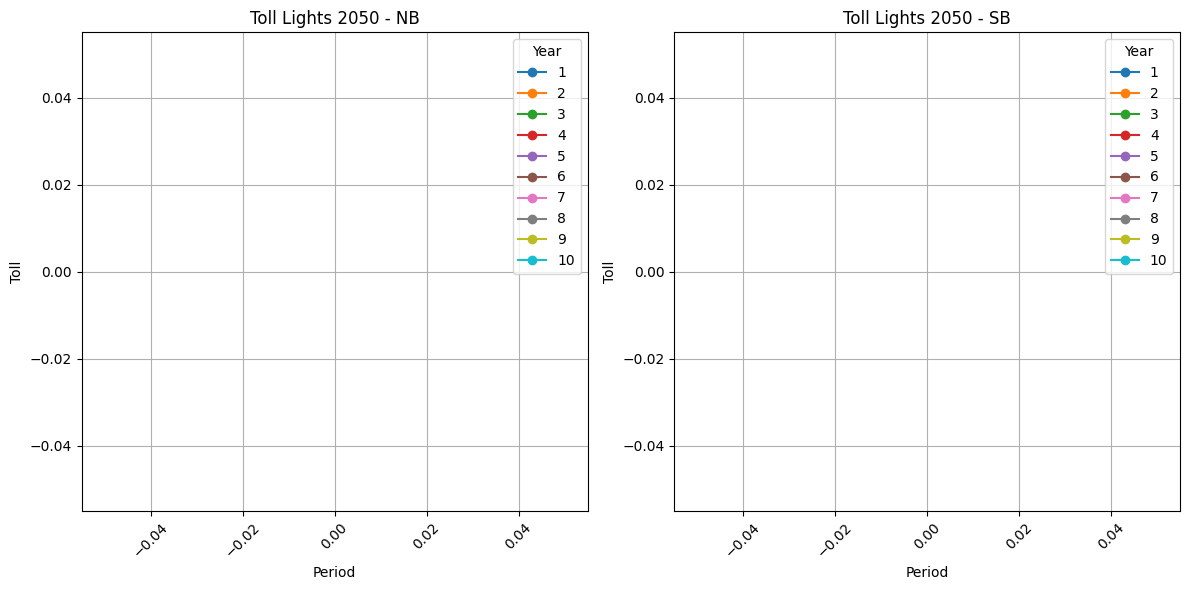

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Cargar CSV
# model_run = pd.read_csv("outputs\\2025-09-02\\19-01-04_1\\model_run.csv")
# model_run = pd.read_csv("outputs\\2025-09-10\\18-28-56_1\\model_run.csv")
# model_run = pd.read_csv("outputs\\2025-09-12\\18-59-17_1\\model_run.csv")
model_run = pd.read_csv(f"{run_folder}\\model_run.csv")

# model_run = pd.read_csv("outputs\\2025-10-02\\cap_v2\\model_run.csv")

year_val = 2050

model_run = model_run.loc[model_run["Year"] == year_val]

model_run.loc[model_run['Period'] == 'Night', 'TollLights'] = 0.5

# 2. Definir años y direcciones
segments = [1,2,3,4,5,6,7,8,9,10]
directions = ["NB", "SB"]

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    for segment in segments:
        df = model_run[(model_run["Segment"] == segment) & (model_run["Direction"] == direction)]
        plt.plot(df["Period"], df["TollLights"], marker='o', linestyle='-', label=str(segment))
        
    
    plt.title(f"Toll Lights {year_val} - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Toll")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (0,) and (8,)

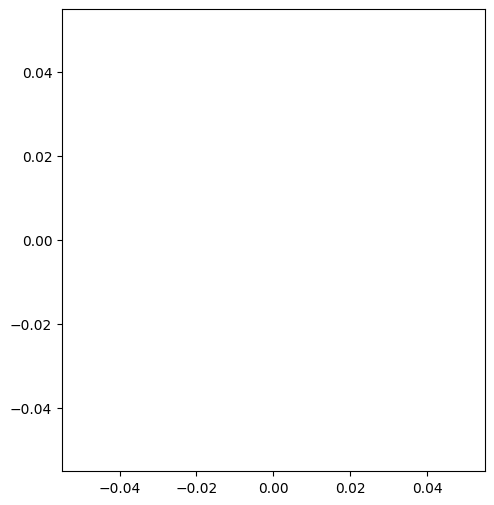

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# model_run = pd.read_csv("outputs\\2025-09-12\\18-59-17_1\\model_run.csv")
# model_run = pd.read_csv("outputs\\2025-09-11\\total_v1\\model_run.csv")
# model_run = pd.read_csv("outputs\\2025-09-10\\18-28-56_1\\model_run.csv")
# model_run = pd.read_csv(f"outputs\\2025-10-08\\test_new_cap_v3\\model_run.csv")
# model_run = pd.read_csv("outputs\\2025-09-15\\cap_categories_v1\\model_run.csv")
# model_run = pd.read_csv("outputs\\2025-09-18\\15-26-30_1\\model_run.csv")
# model_run = pd.read_csv("outputs\\2025-10-02\\cap_v2\\model_run.csv")

# model_run = pd.read_csv(f"{run_folder}\\model_run.csv")

years = [2032, 2040, 2050]
directions = ["NB", "SB"]

model_run = model_run.loc[model_run["Segment"] == 2] #2

model_run.loc[model_run['Period'] == 'Night', 'TollLights'] = 0.5
model_run.loc[model_run['Period'] == 'PM-Late', 'TollLights'] = 0.5

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
        
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        #if year == 2050:
        #    df["TollLights"] = df["TollLights"].clip(upper=5.15)
        #if year == 2040:
        #    df["TollLights"] = df["TollLights"].clip(upper=4.2)
        #if year == 2032:
        #    df["TollLights"] = df["TollLights"].clip(upper=3.6)

        plt.plot(df["Period"], df["TollLights"], marker='o', linestyle='-', label=str(year))   
    
    
    df_cap_50 = pd.DataFrame({"Value": [5.15] * 8})
    df_cap_40 = pd.DataFrame({"Value": [4.2] * 8})
    df_cap_32 = pd.DataFrame({"Value": [3.6] * 8})
    plt.plot(df["Period"], df_cap_50["Value"], marker='o', linestyle='--', color='green') 
    plt.plot(df["Period"], df_cap_40["Value"], marker='o', linestyle='--', color='orange') 
    plt.plot(df["Period"], df_cap_32["Value"], marker='o', linestyle='--', color='blue')
    df_cap_s50 = pd.DataFrame({"Value": [5.15/2] * 8})
    df_cap_s40 = pd.DataFrame({"Value": [4.2/2] * 8})
    df_cap_s32 = pd.DataFrame({"Value": [3.6/2] * 8})
    plt.plot(df["Period"], df_cap_s50["Value"], marker='o', linestyle='--', color='green') 
    plt.plot(df["Period"], df_cap_s40["Value"], marker='o', linestyle='--', color='orange') 
    plt.plot(df["Period"], df_cap_s32["Value"], marker='o', linestyle='--', color='blue') 

    plt.title(f"Toll Lights - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Toll")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

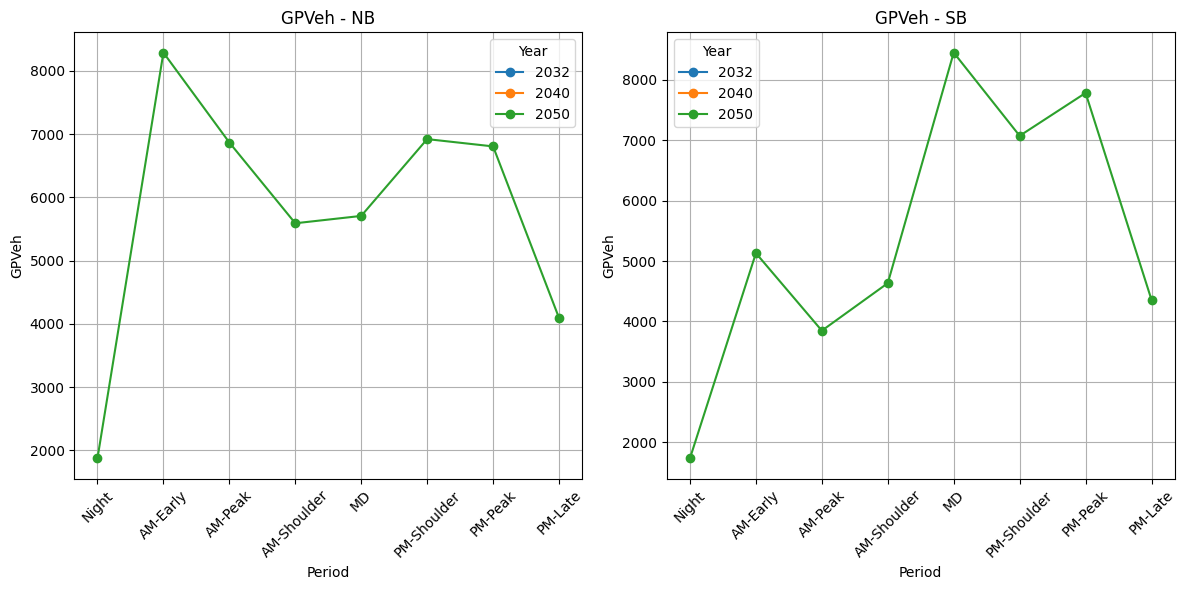

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        plt.plot(df["Period"], df["GPVeh"], marker='o', linestyle='-', label=str(year))
    
    plt.title(f"GPVeh - {direction}")
    plt.xlabel("Period")
    plt.ylabel("GPVeh")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

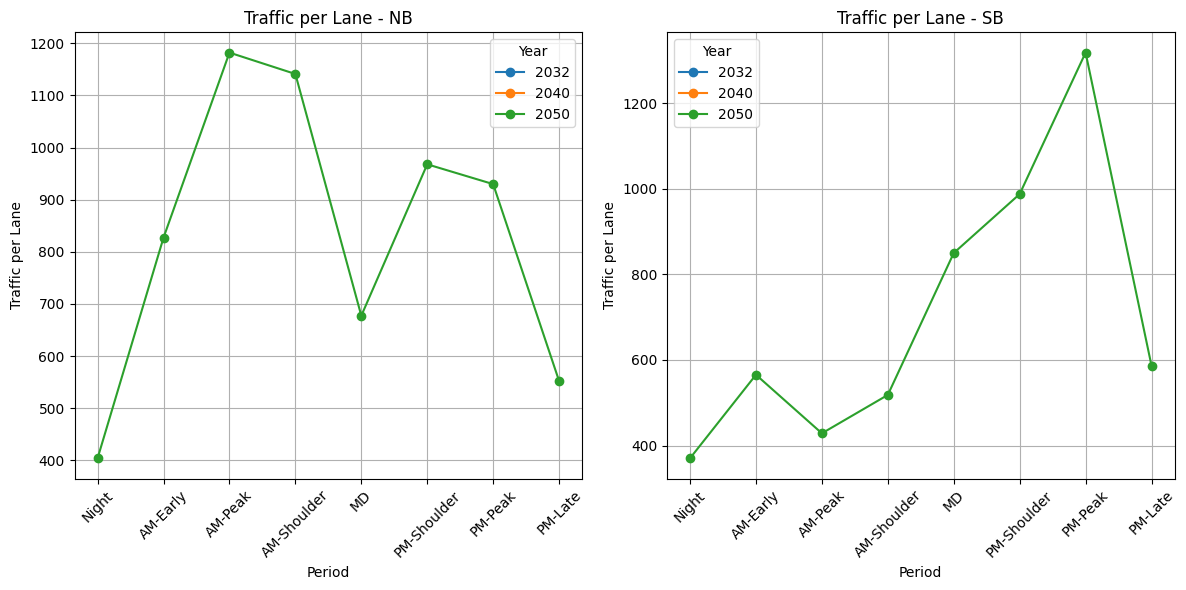

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        plt.plot(df["Period"], df["ML PCE"] / 2, marker='o', linestyle='-', label=str(year))
    
    plt.title(f"Traffic per Lane - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Traffic per Lane")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

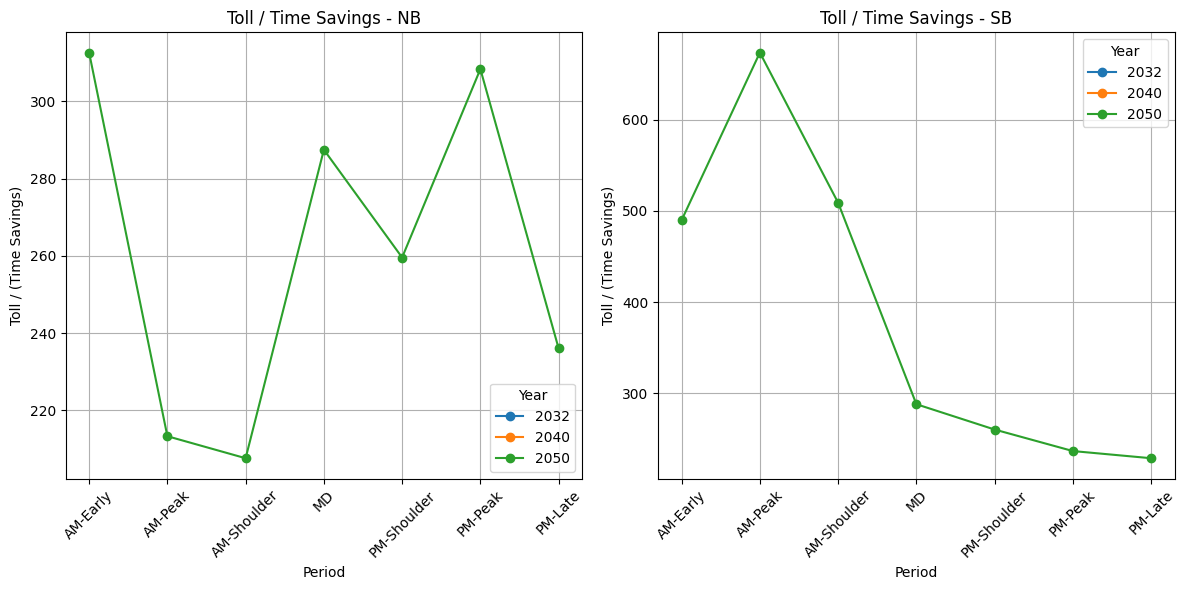

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction) & (model_run["Period"] != 'Night')]
        plt.plot(df["Period"], (60 * df["TollLights"] / (df["Time GP"] - df["Time ML"])), marker='o', linestyle='-', label=str(year))
    
    plt.title(f"Toll / Time Savings - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Toll / (Time Savings)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

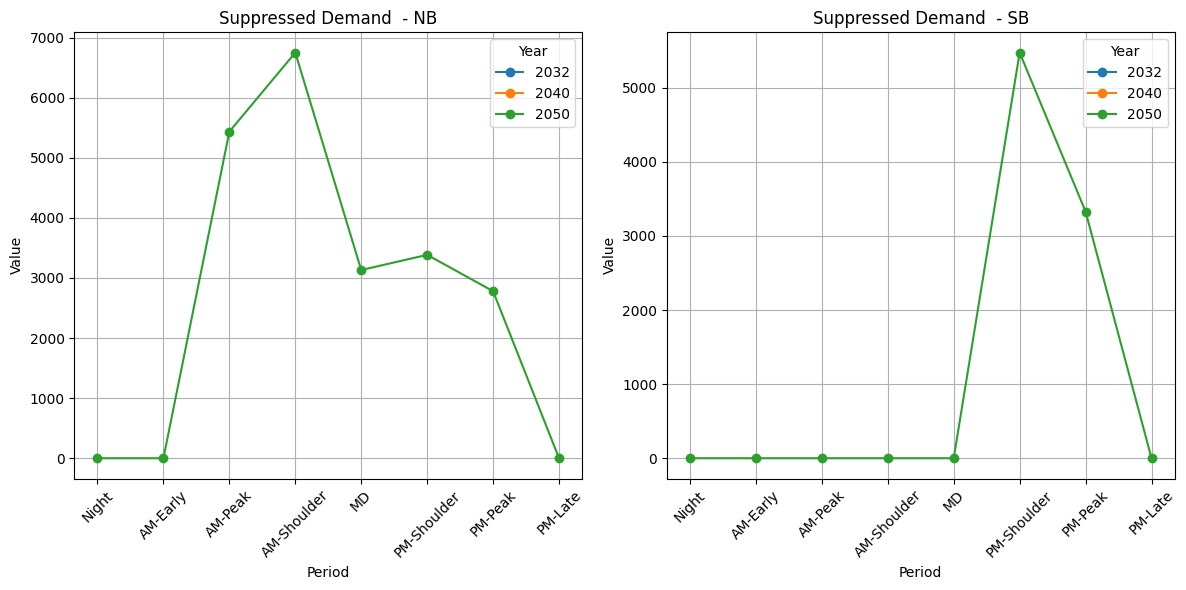

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        plt.plot(df["Period"], df["Suppressed Demand"], marker='o', linestyle='-', label=str(year))
    
    plt.title(f"Suppressed Demand  - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Value")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

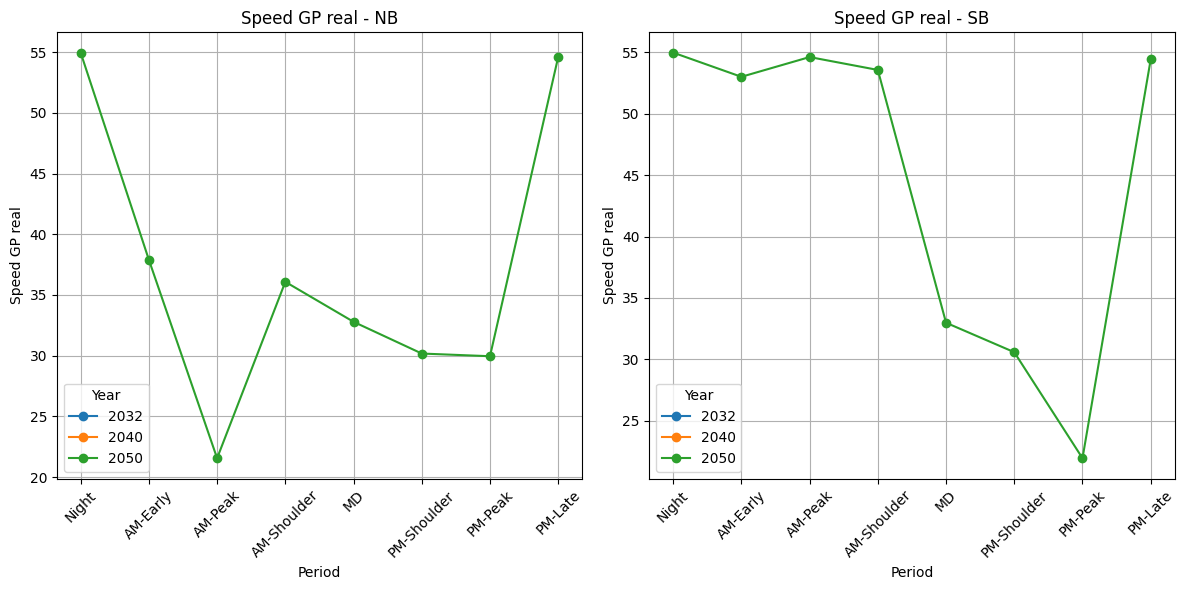

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        plt.plot(df["Period"], df["Speed GP Real"], marker='o', linestyle='-', label=str(year))
    
    plt.title(f"Speed GP real - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Speed GP real")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

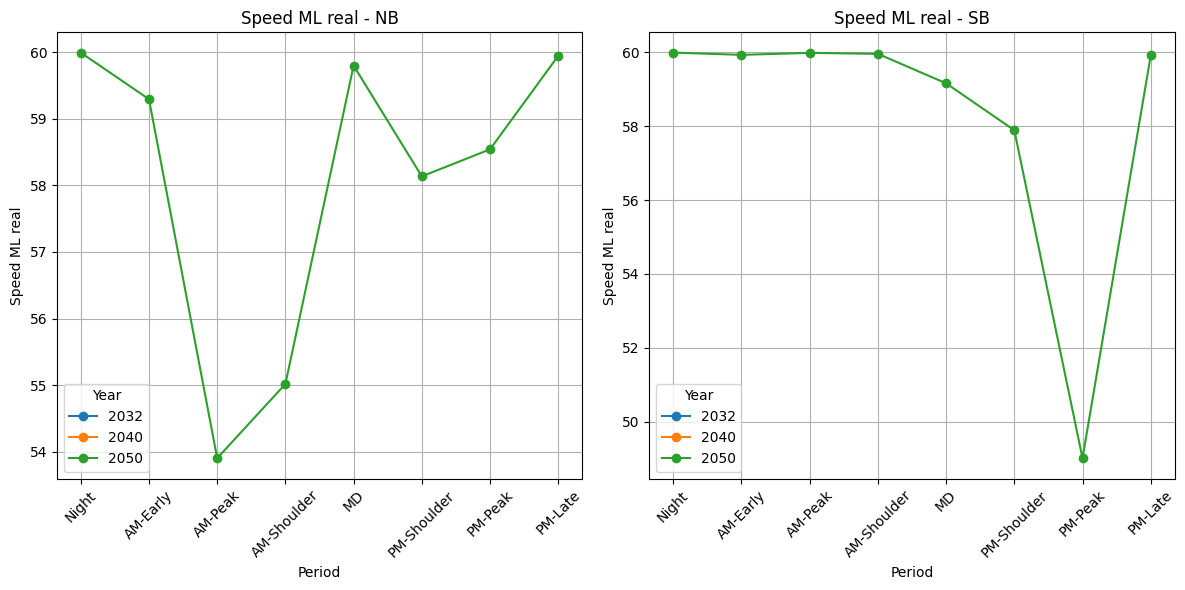

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        plt.plot(df["Period"], df["Speed ML Real"], marker='o', linestyle='-', label=str(year))
    
    plt.title(f"Speed ML real - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Speed ML real")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

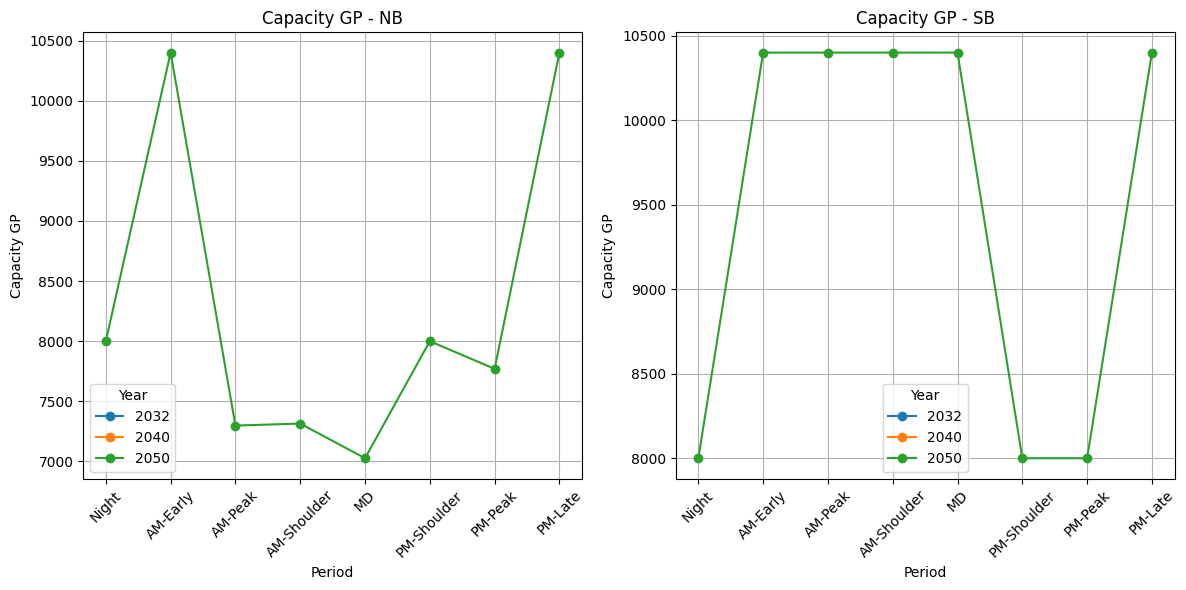

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        plt.plot(df["Period"], df["Capacity GP"], marker='o', linestyle='-', label=str(year))
    
    plt.title(f"Capacity GP - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Capacity GP")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

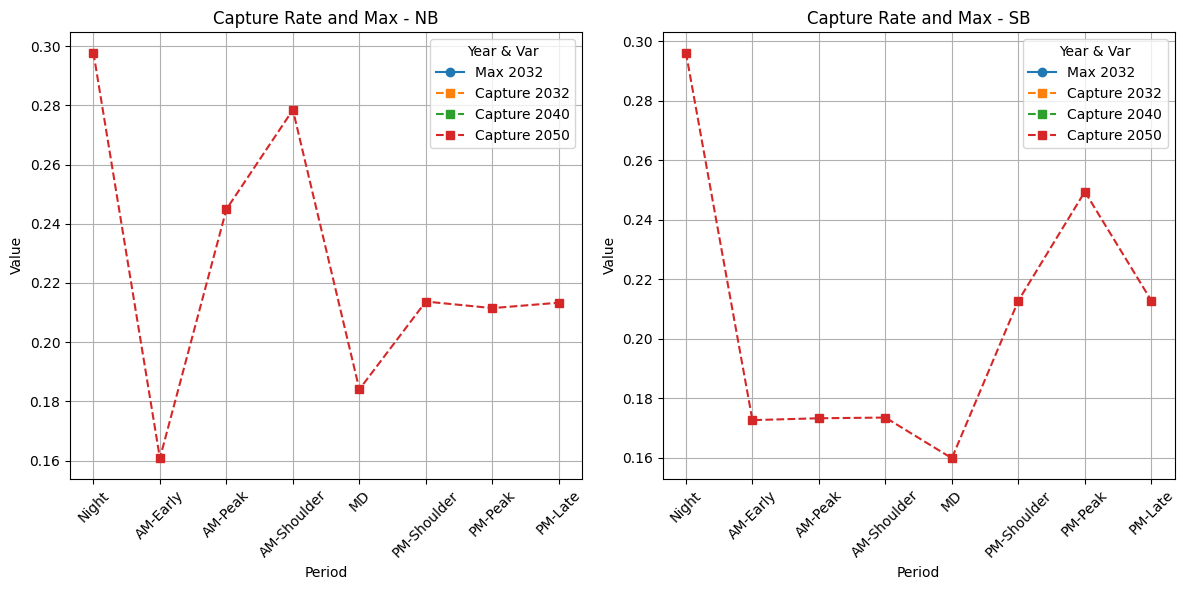

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        
        # Graficar Capture
        if year == years[0]:
            plt.plot(df["Period"], df["MaxCapture"], marker='o', linestyle='-', label=f"Max {year}")
        # Graficar Toll
        plt.plot(df["Period"], df["CaptureRateLights"], marker='s', linestyle='--', label=f"Capture {year}")
    
    plt.title(f"Capture Rate and Max - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Value")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year & Var")

plt.tight_layout()
plt.show()


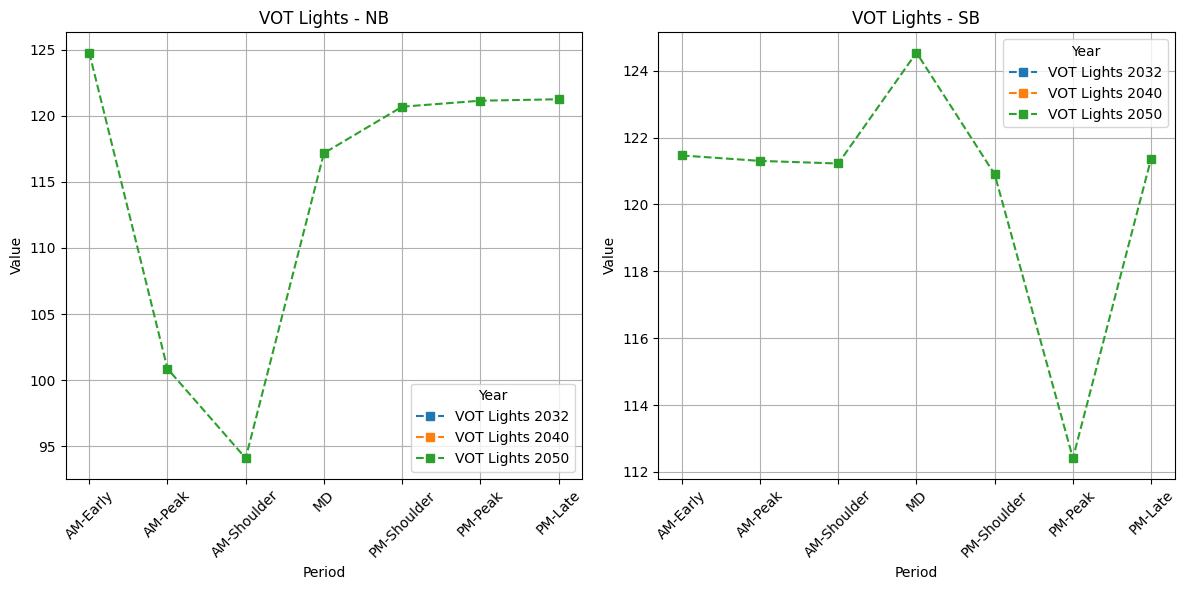

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction) & (model_run["Period"] != "Night")]

        # Graficar Toll
        plt.plot(df["Period"], df["VOT Lights"], marker='s', linestyle='--', label=f"VOT Lights {year}")
    
    plt.title(f"VOT Lights - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Value")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()
